In [24]:
import torch.nn.functional as F
from torchvision import transforms 
from torch.utils.data import DataLoader
import numpy as np
import torch
from torch.optim import Adam
from torch import nn
from datasets import load_dataset
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

In [255]:
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

gpu = 1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Test to see if cpu or gpu is being used
torch.cuda.set_device(device) 
    
# Setting to make GPU computations more efficient
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cuda.matmul.allow_bf16_reduced_precision_reduction = False
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(use_cuda=False)

<unfinished torch.autograd.profile>

### On diffusion models 

This project involves implementing a diffusion model. The implemention will follow the paper linked here: https://arxiv.org/pdf/2006.11239.pdf so please refer to this work for more details if needed. 

The goal will be to implement the code for the diffusion model, find the right configuration to train the model, achieve good accuracy and efficiency and finally interpret how the model learns.  

This project will be working with the FashionMNIST dataset. You can load the data using the below code. 

In [25]:
IMG_SIZE = 28
BATCH_SIZE = 128

# load dataset from the hub
dataset = load_dataset("fashion_mnist")
channels = 1

# define image transformations (e.g. using torchvision)
transform = Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1)
])

# define function
def transforms(examples):
    examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
    del examples["image"]
    return examples

transformed_dataset = dataset.with_transform(transforms).remove_columns("label")

# pin_memory=True is added to increase computational accuracy in gpu
dataloader = DataLoader(transformed_dataset['train'], batch_size=BATCH_SIZE, shuffle=True, drop_last=True, pin_memory=True)

In [26]:
def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.cpu().gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

##### 1. The noising process

Our first step will be to implement the forward process that adds noise to an image. 

We will be adding noise according to a linear schedule, i.e. the noises $\beta_t$, $t=1,...,T$ will come from an equally spaced vector. Implement the `linear_beta_schedule` function. Remember $\alpha_t = 1-\beta_t$ and $\bar \alpha_t = \prod_{s=1}^t \alpha_s$. 

Remember that we have the closed-form solutions for the image at time $t$. Use those in the implementation of `forward_diffusion_sample` instead of a for loop over each noising step. This means you will need to implement `sqrt_one_minus_alphas_cumprod` which represents $\sqrt{1-\bar\alpha_t}$ and `sqrt_alphas_cumprod` which represents $\sqrt{\bar\alpha_t}$. 

Test the function on an image from the dataset using the given code below. 

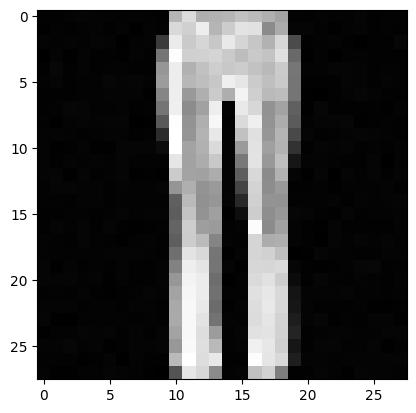

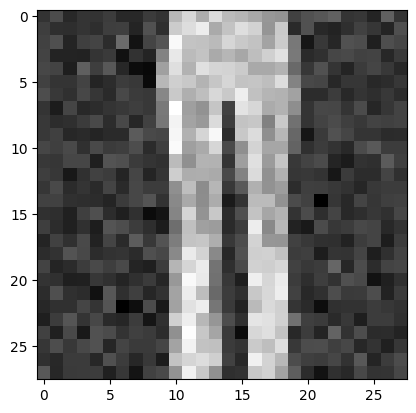

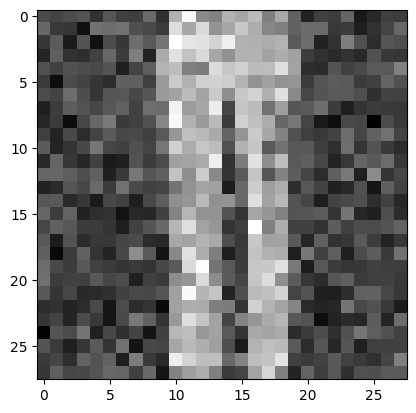

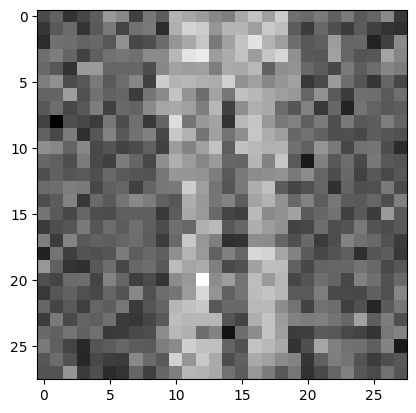

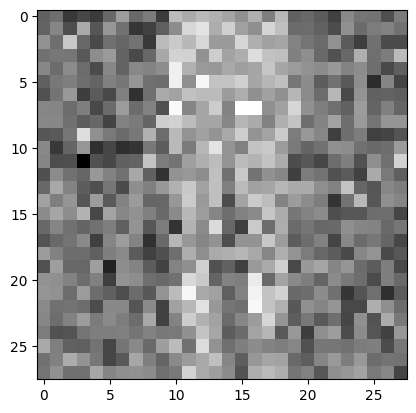

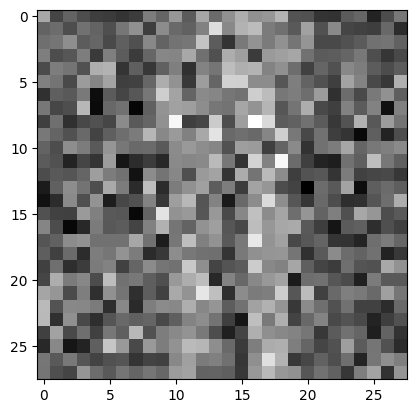

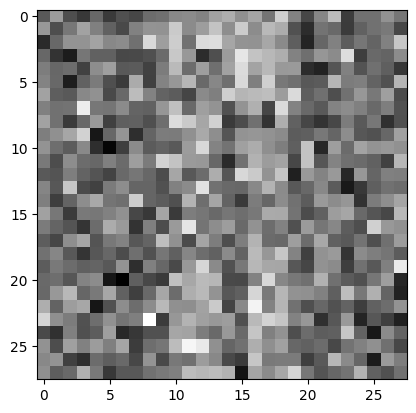

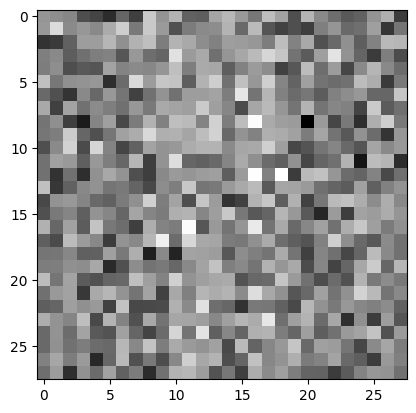

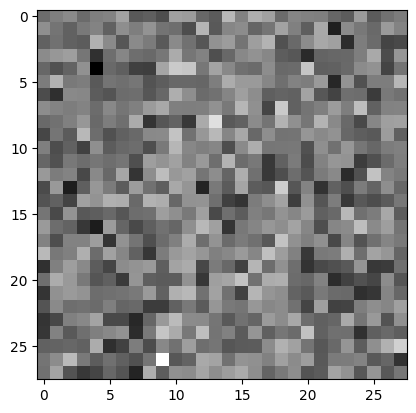

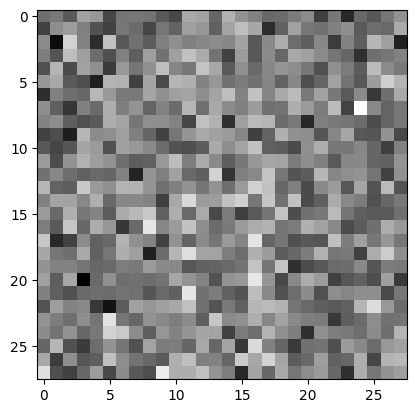

In [27]:

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def forward_diffusion_sample(x_0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, device="cpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    x_t = x_0 * get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape) + noise * get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x_0.shape)
    
    return x_t, noise
    

# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
# Added here is the computations needed for sqrt_alphas_cumprod and sqrt_one_minus_alphas_cumprod
betas = linear_beta_schedule(timesteps=T)

sqrt_alphas_cumprod = torch.sqrt(torch.cumprod(1 - betas, dim = 0))
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - torch.cumprod(1 - betas, dim = 0))

# Simulate forward diffusion
batch = next(iter(dataloader))["pixel_values"]
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    img, noise = forward_diffusion_sample(batch[0,:,:,:], t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod)
    plt.imshow(img.reshape(28, 28), cmap="gray")
    plt.show()

Testing different beta schedules noise, presenting the results for the two settings and discussion how the hyperparameters change the forward sampling. 

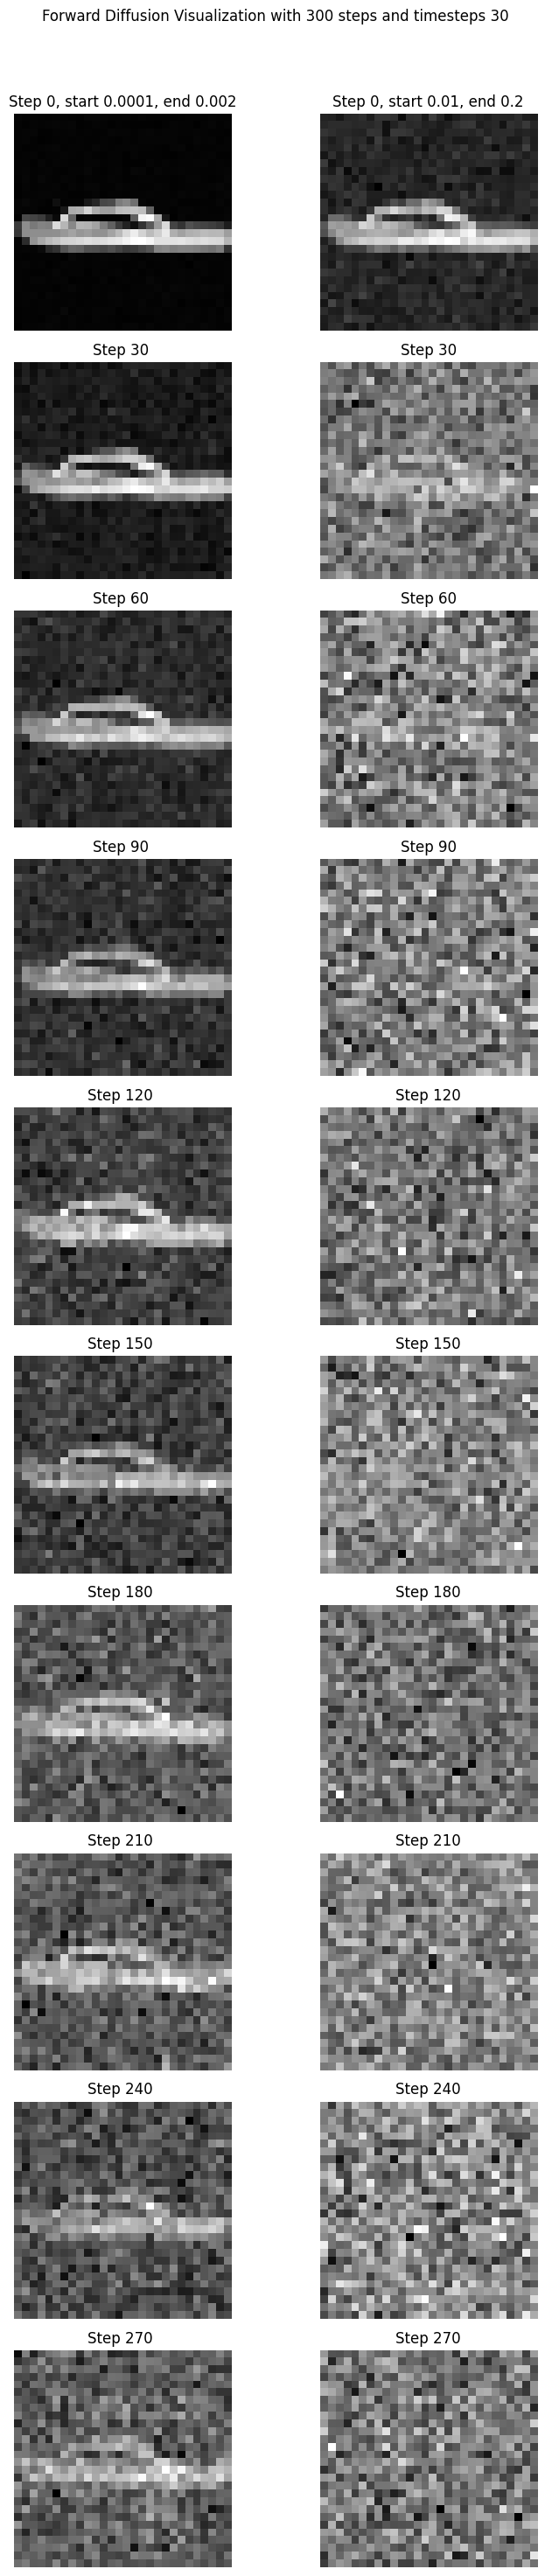

In [28]:
# Define beta schedule
T = 300

start1=0.0001
end1=0.002

betas1 = linear_beta_schedule(timesteps=T,start=start1, end=end1)

# Pre-calculate different terms for closed form
# Added here is the computations needed for sqrt_alphas_cumprod and sqrt_one_minus_alphas_cumprod
sqrt_alphas_cumprod1 = torch.sqrt(torch.cumprod(1 - betas1, dim = 0))
sqrt_one_minus_alphas_cumprod1 = torch.sqrt(1 - torch.cumprod(1 - betas1, dim = 0))

start2=0.01
end2=0.2

betas2 = linear_beta_schedule(timesteps=T,start=start2, end=end2)

# Pre-calculate different terms for closed form
# Added here is the computations needed for sqrt_alphas_cumprod and sqrt_one_minus_alphas_cumprod
sqrt_alphas_cumprod2 = torch.sqrt(torch.cumprod(1 - betas2, dim = 0))
sqrt_one_minus_alphas_cumprod2 = torch.sqrt(1 - torch.cumprod(1 - betas2, dim = 0))

num_images = 10
stepsize = int(T/num_images)

fig, axes = plt.subplots(num_images, 2, figsize=(8, 3 * num_images))

fig.suptitle(f"Forward Diffusion Visualization with {T} steps and timesteps {stepsize}")
for idx in range(0, T, stepsize):
    t = torch.tensor([idx], dtype=torch.int64)
    img1, noise1 = forward_diffusion_sample(batch[[1], :, :, :], t, sqrt_alphas_cumprod1, sqrt_one_minus_alphas_cumprod1)
    img2, noise2 = forward_diffusion_sample(batch[[1], :, :, :], t, sqrt_alphas_cumprod2, sqrt_one_minus_alphas_cumprod2)
    
    ax1 = axes[idx // stepsize, 0]
    ax1.imshow(img1.squeeze(), cmap="gray")  
    ax1.set_title(f"Step {idx} ")
    if idx == 0:
        ax1.set_title(f"Step {idx}, start {start1}, end {end1}")
    ax1.axis('off')
    ax1.set_xticks([]) 
    ax1.set_yticks([])  
    
    ax2 = axes[idx // stepsize, 1]
    ax2.imshow(img2.squeeze(), cmap="gray") 
    ax2.set_title(f"Step {idx}")
    if idx == 0:
        ax2.set_title(f"Step {idx}, start {start2}, end {end2}")
    
    ax2.axis('off')
    ax1.set_xticks([])  
    ax1.set_yticks([])  

fig.tight_layout()

fig.subplots_adjust(top=0.94)

plt.show()



The larger the start or end values for the beta schedule are, the smaller $\sqrt{\bar\alpha_t}$ becomes at each timestep. This causes the forward diffusion sampler to return an image with a larger noise influence and a smaller influence from the original image per step. In the plots above different start and end values are picked to illustrate this fact.

##### 2. The model for the noise

We use a simple form of a UNet to predict the noise in the image. The input into the neural network will be a noisy image and the ouput from the model will be the noise in the image. It is important to also pass in the timestep into the neural network (so the model knows at which time we want to denoise the image) and we do this by passing it through a sinusoidal position embedding. 

Written in the code below is the Sinusoidal Position Embedding. This should output a matrix $PE$ of size `[timesteps, dimension]` with elements:

\begin{align}
&PE_{pos,2i} = \sin\left(\frac{pos}{10000^{2i/dim}}\right),\\
&PE_{pos,2i+1} = \cos\left(\frac{pos}{10000^{2i/dim}}\right),
\end{align}
where `pos` refers to the time position and `i` refers to the dimension position and `dim` the total dimension we are working with. 

Use however the following identity to implement: 
\begin{align}
\frac{pos}{10000^{2i/dim}} = \exp\left(\log(pos) - \frac{2i}{dim}\log(10000)\right).
\end{align}

In [10]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        # Get torch tensor 1,2,...,dim
        dimention_index = torch.arange(self.dim)
        
        # Get log of time at each value 
        # Equivalent to log(pos) is equation above
        time_log = torch.log(time).unsqueeze(-1) 
        
        dim_log = ((2 * dimention_index / self.dim)*np.log(10000)).unsqueeze(0)
        
        PE = torch.exp(time_log - dim_log.to(time_log.device))
        
        PE[:, ::2] = torch.sin(PE[:, ::2])
        PE[:, 1::2] = torch.cos(PE[:, 1::2])

        return PE

Visualise the positional embeddings with arbitary time and dimension and discussion about what position embeddings do.

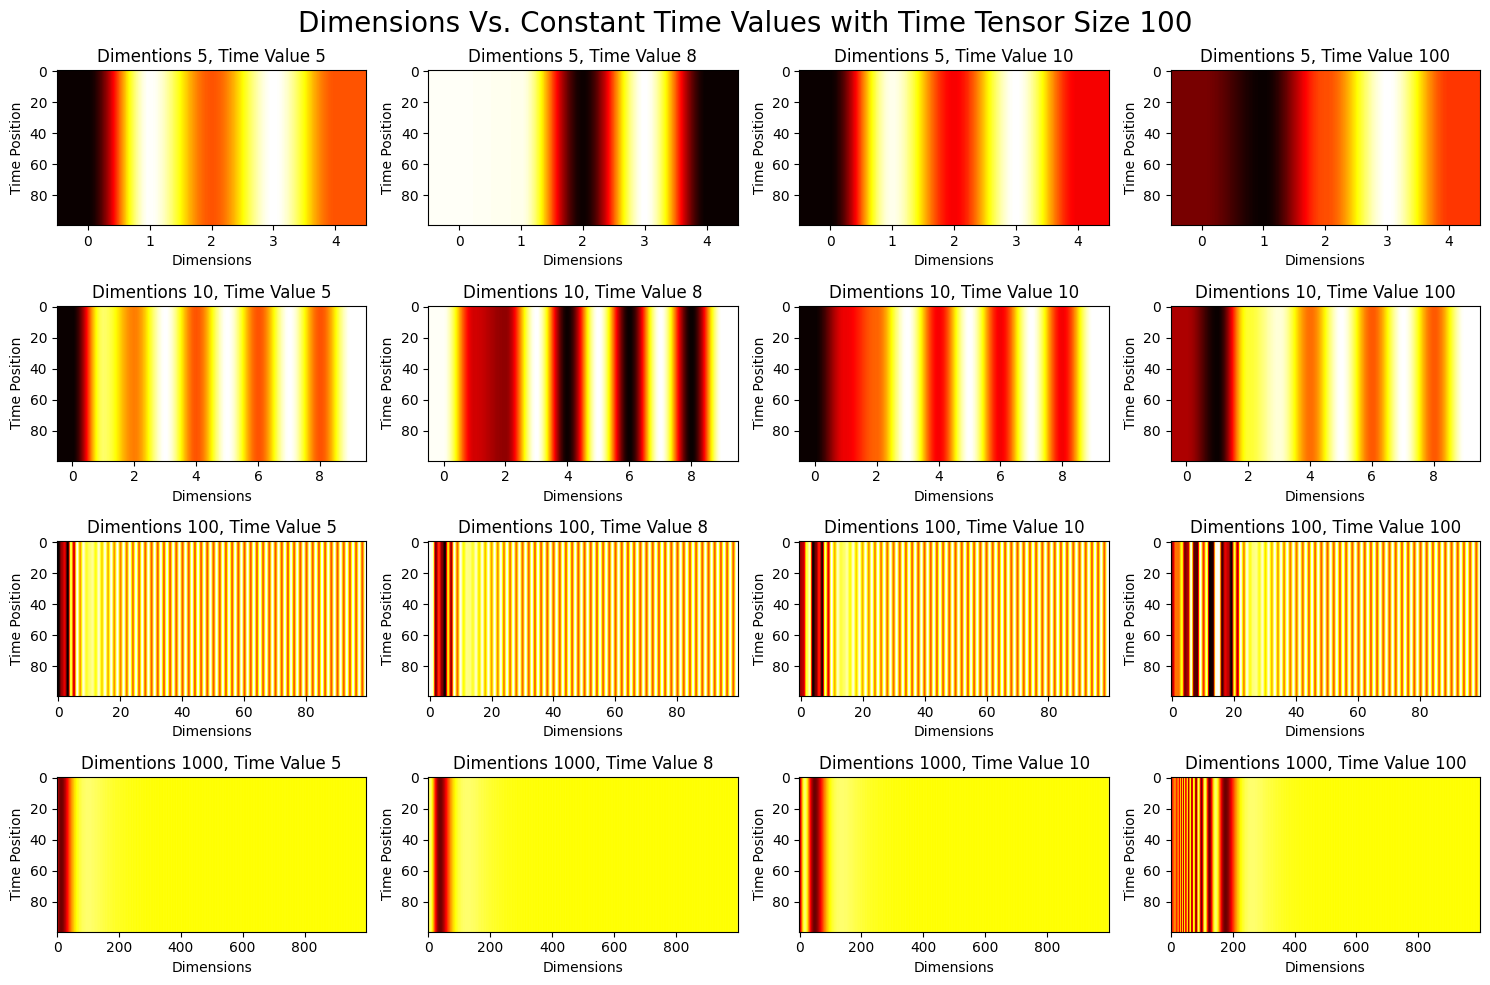

In [261]:
dims = [5,10,100,1000]
times = [5,8,10,100]
tensor_size = 100


fig, axs = plt.subplots(len(dims), len(times), figsize=(15, 10))
fig.suptitle(f"Dimensions Vs. Constant Time Values with Time Tensor Size {tensor_size}"
             , fontsize=20)

for i, dim in enumerate(dims):
    for j, time in  enumerate(times):
        s = SinusoidalPositionEmbeddings(dim)
        t = torch.tensor([time]*tensor_size)
        mat = s.forward(t)
        axs[i, j].imshow(mat, cmap='hot', aspect='auto')
        axs[i, j].set_title(f"Dimentions {dim}, Time Value {time}")
        axs[i, j].set_xlabel('Dimensions')
        axs[i, j].set_ylabel('Time Position')
plt.tight_layout()
plt.show()

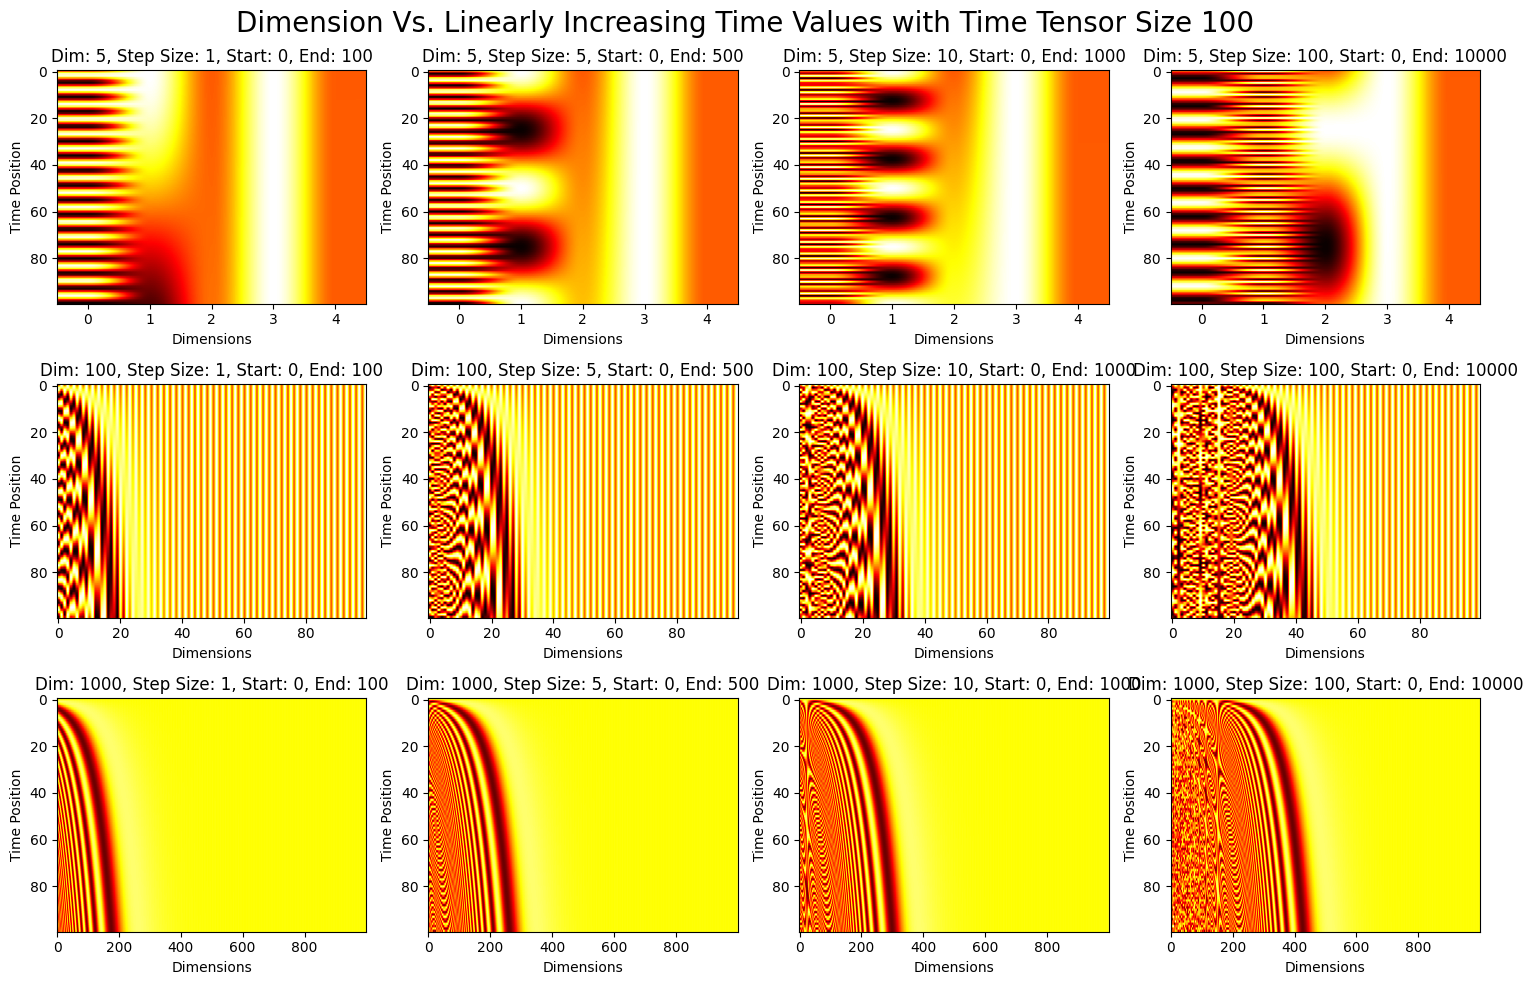

In [265]:
dims = [5,100,1000]
times = [1,5,10,100]
tensor_size = 100

fig, axs = plt.subplots(len(dims), len(times), figsize=(15, 10))
fig.suptitle(f"Dimension Vs. Linearly Increasing Time Values with Time Tensor Size {tensor_size}"
             , fontsize=20)

for i, dim in enumerate(dims):
    for j, time in  enumerate(times):
        s = SinusoidalPositionEmbeddings(dim)
        t = torch.arange(0,time*tensor_size,time)
        mat = s.forward(t)
        axs[i, j].imshow(mat, cmap='hot', aspect='auto')
        axs[i, j].set_title(f"Dim: {dim}, Step Size: {time}, Start: {0}, End: {time*tensor_size}")
        axs[i, j].set_xlabel('Dimensions')
        axs[i, j].set_ylabel('Time Position')

plt.tight_layout()
plt.show()

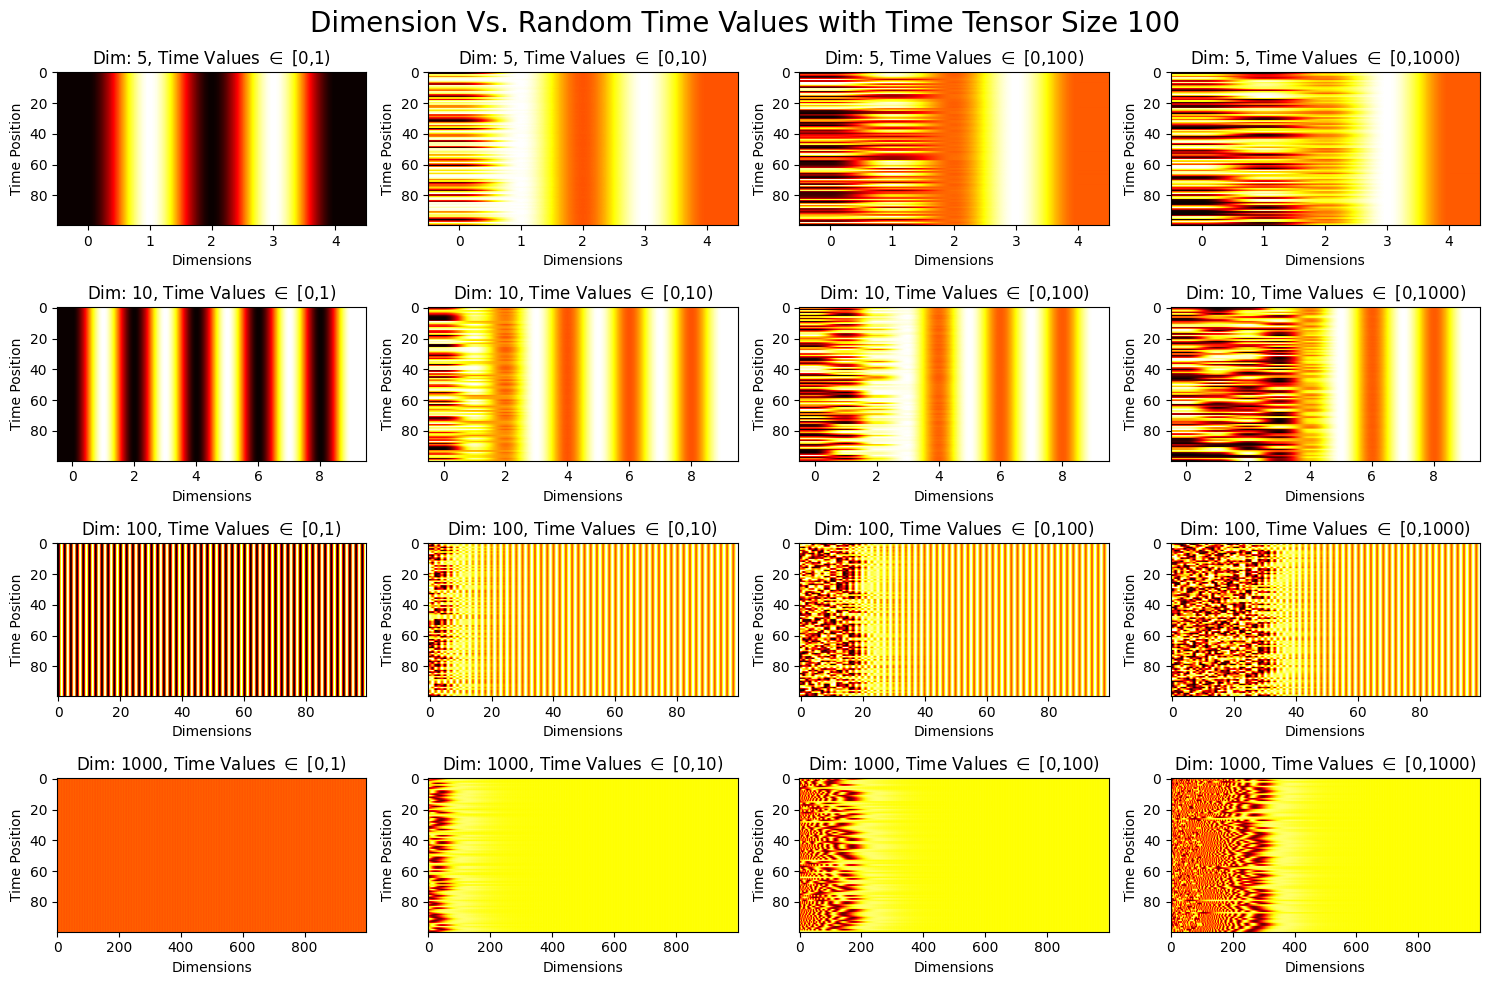

In [267]:
dims = [5,10,100,1000]
times = [1,10,100, 1000]
tensor_size = 100


fig, axs = plt.subplots(len(dims), len(times), figsize=(15, 10))
fig.suptitle(f"Dimension Vs. Random Time Values with Time Tensor Size {tensor_size}", fontsize=20)
for i, dim in enumerate(dims):
    for j, times_step in  enumerate(times):
        s = SinusoidalPositionEmbeddings(dim)
        t = torch.randint(0, times_step, (tensor_size,))
        mat = s.forward(t)

        axs[i, j].imshow(mat, cmap='hot', aspect='auto')
        axs[i, j].set_title(f"Dim: {dim}, Time Values $\in$ [0,{times_step})")
        axs[i, j].set_xlabel('Dimensions')
        axs[i, j].set_ylabel('Time Position')

plt.tight_layout()
plt.show()


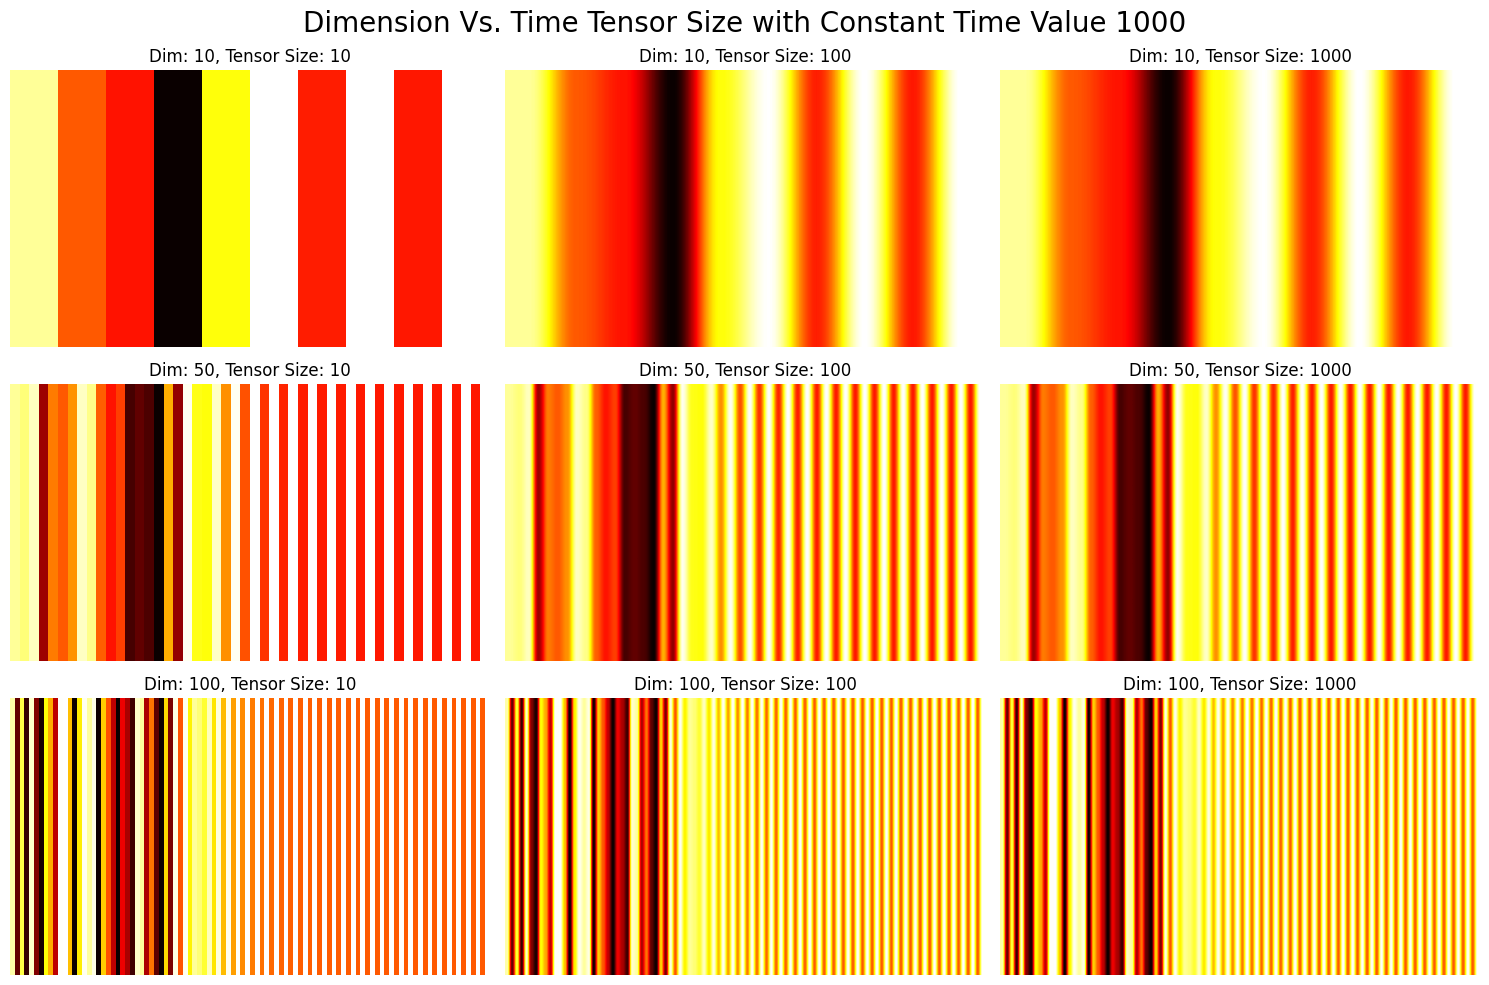

In [271]:
dims = [10,50,100]
tensor_sizes = [10,100,1000]
time = [1000]


fig, axs = plt.subplots(len(dims), len(tensor_sizes), figsize=(15, 10))
fig.suptitle(f"Dimension Vs. Time Tensor Size with Constant Time Value {time[0]}", fontsize=20)# Iterate over dimensions and time values
for i, dim in enumerate(dims):
    for j, tensor_size in  enumerate(tensor_sizes):
        s = SinusoidalPositionEmbeddings(dim)
        t = torch.tensor(time*tensor_size)
        mat = s.forward(t)
        axs[i, j].imshow(mat, cmap='hot', aspect='auto')
        axs[i, j].set_title(f"Dim: {dim}, Tensor Size: {tensor_size}")
        axs[i, j].axis('off')
plt.tight_layout()
plt.show()

Position embeddings is a way to add timestep information into a model so it can better understand the relationship between the what is being embedded (in this case timesteps) and the image data that will passed into the model. Position embeddings does this without using any form of recurrence or convolutions. Sinusoidal Position embeddings can be particularly useful because, as stated in the cited paper above, it can expand to input data of a different size than the data used in training

Filled in below is the code for a Block, that will make up the final UNet. 

Remember that in the UNet architecture, we have a downsampling phase and an upsampling phase. Depending on which phase we are in, we need to make use of the up or down-sample operations. 

The Block below preforms a single up or down step while also embedding time data. If the output channel (out_ch) is half the input channel's (in_ch) value the down-step section will half the channel and image dimentions, the up-step section will quater the channel dimentions and half the image dimentions. The `nn.Conv2d` functions are used to add weights and biases, and to change the input data's dimentions, while the `nn.Linear`, ` nn.BatchNorm2d` and `nn.ReLU` transformations of the input data.



In [11]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        '''
        in_ch refers to the number of channels in the input to the operation and out_ch how many should be in the output
        '''
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t):
        '''
        Define the forward pass making use of the components above. 
        Time t should get mapped through the time_mlp layer + a relu
        The input x should get mapped through a convolutional layer with relu / batchnorm
        The time embedding should get added the output from the input convolution 
        A second convolution should be applied and finally passed through the self.transform. 
        '''
        
        # time_mlp layer
        t = self.time_mlp(t)
        # relu layer
        t = self.relu(t)
        
        # first convolutional layer
        x = self.conv1(x)
        
        # relu layer
        x = self.relu(x)
        
        # batchnorm 1
        x = self.bnorm1(x) 
        
        # Shape t to be the size of x
        # Add t
        x += t.unsqueeze(-1).unsqueeze(-1).expand_as(x)
        
        # Second convolutional layer
        x = self.conv2(x)
        
        
        # batchnorm 2
        x = self.bnorm2(x)
        
        
        # Final Transformation
        x = self.transform(x)
        
        return x 

The above code is used to fill in the code for the UNet below. 

In [12]:
class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 1 # image_channels is 1 since the images are black and white
        down_channels = (64, 128, 256)
        up_channels = (256, 128, 64) # Define your up_channels
        out_dim = 1  # Define your out_dim
        time_emb_dim = 64 # Define your time_emb_dim
        
        # Time embedding consists of a Sinusoidal embedding, a linear map that maintains the dimensions and a rectified linear unit activation.         
        self.time_emb = SinusoidalPositionEmbeddings(time_emb_dim)
        self.Linear = nn.Linear(time_emb_dim, time_emb_dim)
        self.relu = nn.ReLU()
        
        # Initial projection consisting of a map from image_channels to down_channels[0] with a filter size of e.g. 3 and padding of 1.         
        self.initial_conv = nn.Conv2d(image_channels, down_channels[0], kernel_size=3, padding=1)
        
        # Downsample: use the Blocks given above to define down_channels number of downsampling operations. These operations should cha
        self.downsample_conv = nn.ModuleList([Block(down_channels[i], down_channels[i+1], time_emb_dim) for i in range(len(down_channels)-1)])
        

        # Upsample
        # Same logic as the downsample
        self.upsample_conv = nn.ModuleList([Block(up_channels[i], up_channels[i + 1], time_emb_dim, up = True) for i in range(len(up_channels)-1)])
        
        # Final output: given by a final convolution that maps up_channels[-1] to out_dim with a kernel of size 1. 
        # Final output
        self.final_conv = nn.Conv2d(up_channels[-1], out_dim, kernel_size=1, stride=1)

    def forward(self, x, timestep):
        # Time embedding
        time_emb = self.time_emb(timestep)
        time_emb = self.Linear(time_emb).squeeze(1)
        time_emb = self.relu(time_emb)
        
        # Initial conv
        x = self.initial_conv(x)
        
        # Track residuals
        down_tracker = []
        down_tracker.append(x)
        
        
        # Downsampling phase
        for block in self.downsample_conv:
            x = block(x, time_emb)
            # Save Downsampling Convolutions
            down_tracker.append(x)

        # Upsample phase
        for i, block in enumerate(self.upsample_conv):
            # Combine with Downsampling Convolutions
            x = torch.cat((x, down_tracker[::-1][i]), dim=1)
            # Upsample steps
            x = block(x, time_emb)

        # Final Convolution
        x = self.final_conv(x)
        
        return x

FINALLY! define a loss function. Note that this loss function should take x_0 and t to sample the forward diffusion model, get a noisy image, use this noisy image in the model to get the noise added and finally compare true added noise and model outputs added noise.

In [13]:
def get_loss(model, x_0, t, return_image = False):
    '''
    Define the right loss given the model, the true x_0 and the time t
    '''
    # Sample noisy/processed image
    noisy_image, noise = forward_diffusion_sample(x_0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, device=device)
    
    # Prediction from model
    noise_pred = model(noisy_image, t)
    
    # Mean Squared Error loss is used to train the model
    loss = F.mse_loss(noise_pred, noise)
    
    '''
    For analysis the Mean Squared Error for different times is tracked
    '''
    
    # Mean Squared Error loss for 0=<t<100
    loss_time_less_100 = F.mse_loss(noise_pred[t<100,:,:,:], noise[t<100,:,:,:]) 
    
    # Mean Squared Error loss for 100=<t<200
    loss_time_less_200 = F.mse_loss(noise_pred[(t >= 100) & (t < 200),:,:,:], noise[(t >= 100) & (t < 200),:,:,:])
    
    # Mean Squared Error loss for 200=<t<300
    loss_time_less_300 = F.mse_loss(noise_pred[200<=t,:,:,:], noise[200<=t,:,:,:])

    if return_image==True:
        # For analysis some predicted image were found based on the predicted noise
        image_pred = (noisy_image - noise_pred * 
                      get_index_from_list(sqrt_one_minus_alphas_cumprod
                                          , t, x_0.shape)) / get_index_from_list(sqrt_alphas_cumprod
                                                                                 , t, x_0.shape)
        return loss, loss_time_less_100, loss_time_less_200, loss_time_less_300, [noisy_image[0], image_pred[0], x_0[0]]
    else:
    	return loss, loss_time_less_100, loss_time_less_200, loss_time_less_300

##### Part 3: The sampling

A piece of code that can be used to predict the noise and return the denoised image. This function works on a single image and make sure that the function can be used in the `sample` function properly. Note that we will need the `posterior_variance` denoted by $\sigma$ in the paper and the `sqrt_recip_alphas` given by $1/\alpha_t$. The value of $\sigma$ is taken from the paper. 

In [218]:
## In use
T = 300

betas = linear_beta_schedule(timesteps=T)

# define alphas 
alphas_cumprod = torch.cumprod((1. - betas), axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)



@torch.no_grad()
def sample_timestep(x, t, i, posterior_variance, sqrt_one_minus_alphas_cumprod, sqrt_alphas_cumprod, model):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    Note that it also needs additional arguments about the posterior_variance, sqrt_minus_alphas_cumprod and sqrt_recip_alphas. 
    """

    if i == 0:
        beta_t = 1 - get_index_from_list(sqrt_alphas_cumprod, t, x.shape)**2
        sqrt_recip_alphas_t = 1 / get_index_from_list(sqrt_alphas_cumprod.T, t, x.shape)
    else:
        beta_t = (1 - (get_index_from_list(sqrt_alphas_cumprod, t, x.shape) / get_index_from_list(sqrt_alphas_cumprod, t-1, x.shape))**2)
        sqrt_recip_alphas_t = get_index_from_list(sqrt_alphas_cumprod.T, t-1, x.shape) / get_index_from_list(sqrt_alphas_cumprod.T, t, x.shape)
    
    sqrt_one_minus_recip_alphas_cumprod_t = 1 / get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x.shape)
    
    Predicted_image = sqrt_recip_alphas_t * (
        x.cuda() - beta_t * model(x.cuda(), t.cuda()) * sqrt_one_minus_recip_alphas_cumprod_t
    )
    
    if i == 0:
        return Predicted_image 
    else:
        posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        Back_step_image = Predicted_image + torch.sqrt(posterior_variance_t) * noise.cuda()
        return Back_step_image

@torch.no_grad()
def sample(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape)
    imgs = []
    for i in tqdm(reversed(range(0, T)), desc='sampling loop time step', total=T):
        
        t = torch.full((b,), i, device=device, dtype=torch.long)
        
        img = sample_timestep(img, t, i, posterior_variance
                              , sqrt_one_minus_alphas_cumprod, sqrt_alphas_cumprod, model)
        
        imgs.append(img.cpu().numpy())
        
    return imgs


##### Part 4. A training loop and the presention & interpretion of results 

A training loop that instantiates the model, defines an optimiser, defines a number of epochs, iterates over the epochs and the datapoints inside the epoch and for each iteration samples a timestep, uses this timestep to loss function and update parameters based on this. 

Note: this is the part requiring most computational resources. The model needs to be trained in the model for quite a few epochs to get good results

In [16]:
def training_loop(model,learning_rate,num_epochs,show_loss = True):
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  
    
    
    image_pred_tracker = []
    loss_tracker_list = []

    for epoch in range(num_epochs):  
        # Train model
        model.train()
        
        # Keep track of losses
        loss_tracker = 0
        loss_tracker_less_100 = 0
        loss_tracker_less_200 = 0
        loss_tracker_less_300 = 0
        
        # Count number of iterations
        count = 0

        for step, batch in enumerate(dataloader):
            
            # Load in original images
            x_0 = batch["pixel_values"].to(device)

            # Random numbers between [0,T) of size batch size
            timestep = torch.randint(0, T, (BATCH_SIZE,)).to(device)

            # Sample some predicted images for later analysis
            if step==300 and epoch%5==4:
                loss, loss_time_less_100, loss_time_less_200, loss_time_less_300, image_pred = get_loss(model
                                                                                                        , x_0
                                                                                                        , timestep
                                                                                                        ,  return_image = True)
                image_pred_tracker.append(image_pred + [timestep[0]] + [epoch])
            else:
                loss, loss_time_less_100, loss_time_less_200, loss_time_less_300 = get_loss(model
                                                                                            , x_0
                                                                                            , timestep
                                                                                            , return_image = False)

            # Reset to zero gradient
            for param in model.parameters():
                param.grad = None
            loss.backward()
            optimizer.step()

            # Keep track of losses
            loss_tracker += loss.item()
            loss_tracker_less_100 += loss_time_less_100.item()
            loss_tracker_less_200 += loss_time_less_200.item()
            loss_tracker_less_300 += loss_time_less_300.item()
            count +=1
            
        # Print average loss at each training epoch
        if show_loss==True:
            print("Epoch:",epoch+1,"Average MSE Loss:",loss_tracker/count)

        # Put all losses into 1 list
        loss_tracker_list.append([loss_tracker/count
                                  ,loss_tracker_less_100/count
                                 ,loss_tracker_less_200/count
                                  ,loss_tracker_less_300/count])

    return model, loss_tracker_list, image_pred_tracker

In [18]:
model1 = SimpleUnet().cuda()
num_params = sum(p.numel() for p in model1.parameters() if p.requires_grad)
print(f"Number of parameters in the model: {num_params}")
lr = 5e-4
num_epochs = 50
print("Number of epochs used for training: ",num_epochs)
print("Learning rate", lr)
print('-'*50)
model, loss_tracker_list1, image_pred_tracker1 = training_loop(model1
                                                               , lr
                                                               , num_epochs
                                                               , show_loss = True)

Number of parameters in the model: 3712257
Number of epochs used for training:  50
Learning rate 0.0005
--------------------------------------------------
Epoch: 1 Average MSE Loss: 0.14186813395756942
Epoch: 2 Average MSE Loss: 0.09995272968951453
Epoch: 3 Average MSE Loss: 0.09221479573693031
Epoch: 4 Average MSE Loss: 0.08892957628187206
Epoch: 5 Average MSE Loss: 0.08774582966843732
Epoch: 6 Average MSE Loss: 0.08583073642773506
Epoch: 7 Average MSE Loss: 0.08516925621109131
Epoch: 8 Average MSE Loss: 0.0836155168298218
Epoch: 9 Average MSE Loss: 0.08309667217585011
Epoch: 10 Average MSE Loss: 0.0820163121033046
Epoch: 11 Average MSE Loss: 0.08147885475275862
Epoch: 12 Average MSE Loss: 0.08151319380212799
Epoch: 13 Average MSE Loss: 0.08025856426733936
Epoch: 14 Average MSE Loss: 0.08055030043499592
Epoch: 15 Average MSE Loss: 0.08001281287616645
Epoch: 16 Average MSE Loss: 0.07974977541364665
Epoch: 17 Average MSE Loss: 0.07982129821728946
Epoch: 18 Average MSE Loss: 0.0796230291

Finally, after training is done, use the `sample` to sample new images. 

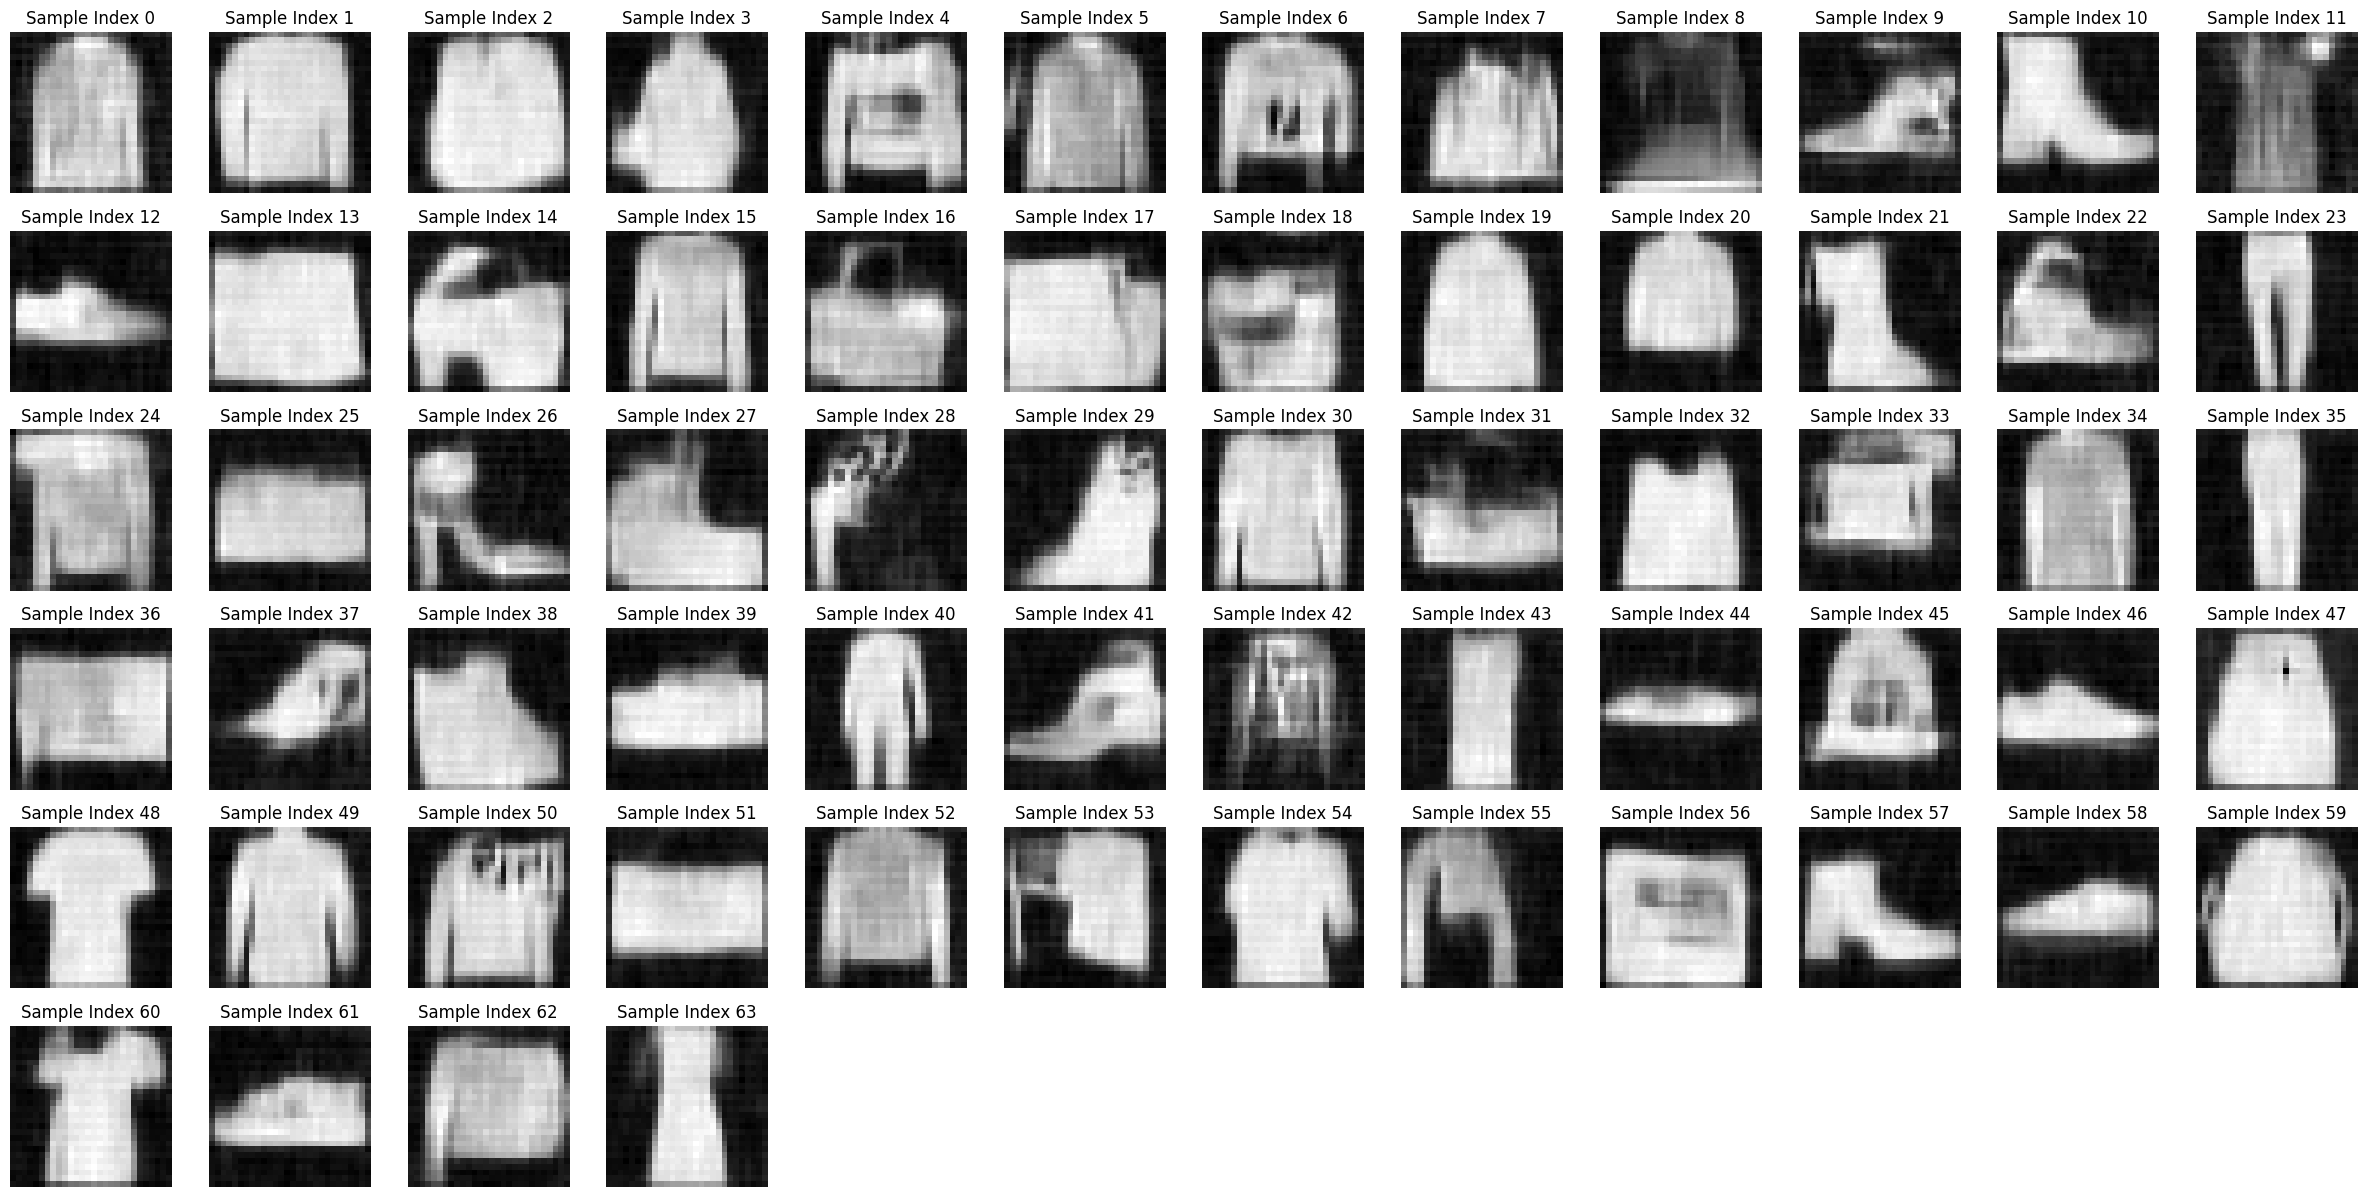

In [277]:

shape = [64,1,28,28]

samples1 = sample(model1, shape)

plt.figure(figsize=(24, 24)) 

for i in range(shape[0]):
    plt.subplot(12, 12, i+1) 
    plt.imshow(samples1[-1][i,:,:,:].reshape(28, 28), cmap="gray") 
    plt.title(f"Sample Index {i}")
    plt.axis('off') 

plt.tight_layout()
plt.show()

Include your best generated samples below.

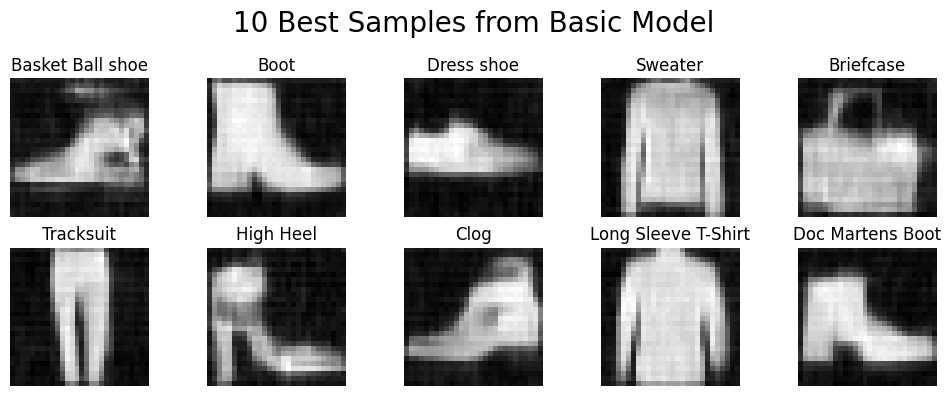

In [276]:
index = [9, 10, 12, 15, 16, 23, 26, 41, 49, 57] 
Names = ['Basket Ball shoe'
         , 'Boot'
         , 'Dress shoe'
         , 'Sweater'
         , 'Briefcase'
         , 'Tracksuit'
         , 'High Heel'
         , 'Clog'
         , 'Long Sleeve T-Shirt'
         , 'Doc Martens Boot']


plt.figure(figsize=(10, 4)) 

plt.suptitle("10 Best Samples from Basic Model", fontsize=20)

for i, idx in enumerate(index):
    plt.subplot(2, 5, i + 1) 
    # Plot each selected sample
    plt.imshow(samples1[-1][idx, :, :, :].reshape(28, 28), cmap="gray")
    plt.title(f"{Names[i]}", fontsize=12)
    plt.axis('off')  

plt.tight_layout()
plt.show()

Included below is the most efficient implementation details. 

The changes made to make the Basic model to make it more efficient are 

- The down channels changed from 64, 128, 256 to 24 ,48, 96. The up channels are changed accordingly

- The time embedding dimentions are changed from 64 to 192.

- A 2-D convolution layer was added between the down sampling phase and the up sampling phase.

In [39]:

class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 1 # image_channels is 1 since the images are black and white
        down_channels = (24 ,48, 96)
        up_channels = (96, 48, 24) # Define your up_channels
        out_dim = 1  # Define your out_dim
        time_emb_dim = 192 # Define your time_emb_dim
        
        middle_channels = down_channels[-1]
        # Time embedding consists of a Sinusoidal embedding, a linear map that maintains the dimensions and a rectified linear unit activation. 
        
        self.time_emb = SinusoidalPositionEmbeddings(time_emb_dim)
        self.Linear = nn.Linear(time_emb_dim, time_emb_dim)
        self.relu = nn.ReLU()
        
        # Initial projection consisting of a map from image_channels to down_channels[0] with a filter size of e.g. 3 and padding of 1. 
        
        self.initial_conv = nn.Conv2d(image_channels, down_channels[0], kernel_size=2, padding=1)
        
        # Downsample: use the Blocks given above to define down_channels number of downsampling operations. These operations should cha
        self.downsample_conv = nn.ModuleList([Block(down_channels[i], down_channels[i+1], time_emb_dim) for i in range(len(down_channels)-1)])
        
        # Middle Convolution is added to improve accuracy
        self.middle_conv = nn.Conv2d(down_channels[-1], middle_channels, kernel_size=3, padding=1)
        

        # Upsample
        # Same logic as the downsample
        self.upsample_conv = nn.ModuleList([Block(up_channels[i], up_channels[i + 1], time_emb_dim, up = True) for i in range(len(up_channels)-1)])
        
        # Final output: given by a final convolution that maps up_channels[-1] to out_dim with a kernel of size 1. 
        # Final output
        self.final_conv = nn.Conv2d(up_channels[-1], out_dim, kernel_size=1, stride=1)

    def forward(self, x, timestep):
        # Time embedding
        time_emb = self.time_emb(timestep)
        time_emb = self.Linear(time_emb).squeeze(1)
        time_emb = self.relu(time_emb)

        
        # Initial conv
        x = self.initial_conv(x)
        
        # Track residuals
        down_tracker = []
        down_tracker.append(x)
        
        #Downsampling phase
        for block in self.downsample_conv:
            x = block(x, time_emb)
            # Save Downsampling Convolutions
            down_tracker.append(x)
            
        #Middle Convolution
        x = self.middle_conv(x)
        
        # Upsample phase
        for i, block in enumerate(self.upsample_conv):
            # Combine with Downsampling Convolutions
            x = torch.cat((x, down_tracker[::-1][i]), dim=1)
            # Upsample steps
            x = block(x, time_emb)
            
        # Final Convolution
        x = self.final_conv(x)
        
        return x
    
model2 = SimpleUnet().cuda()
num_params = sum(p.numel() for p in model2.parameters() if p.requires_grad)
print(f"Number of parameters in the model: {num_params}")
print("Number of parameters less than 929409: ", 929409 - num_params)
lr = 3e-4
num_epochs = 40
print("Number of epochs used for training: ",num_epochs)
print("Learning rate", lr)
print('-'*50)
model2, loss_tracker_list2, image_pred_tracker2 = training_loop(model2, lr, num_epochs, show_loss = True)

Number of parameters in the model: 678961
Number of parameters less than 929409:  250448
Number of epochs used for training:  40
Learning rate 0.0003
--------------------------------------------------
Epoch: 1 Average MSE Loss: 0.20662169359051263
Epoch: 2 Average MSE Loss: 0.12243867492000772
Epoch: 3 Average MSE Loss: 0.11086252139101171
Epoch: 4 Average MSE Loss: 0.10630711811220545
Epoch: 5 Average MSE Loss: 0.10258097160193655
Epoch: 6 Average MSE Loss: 0.09989329694937436
Epoch: 7 Average MSE Loss: 0.09792961439706831
Epoch: 8 Average MSE Loss: 0.09686284055376154
Epoch: 9 Average MSE Loss: 0.0953090801421139
Epoch: 10 Average MSE Loss: 0.09394265092017813
Epoch: 11 Average MSE Loss: 0.09332470842597322
Epoch: 12 Average MSE Loss: 0.09218996954269898
Epoch: 13 Average MSE Loss: 0.0917879559386235
Epoch: 14 Average MSE Loss: 0.09027059344399689
Epoch: 15 Average MSE Loss: 0.09030774948943375
Epoch: 16 Average MSE Loss: 0.08982719842376363
Epoch: 17 Average MSE Loss: 0.088851648454

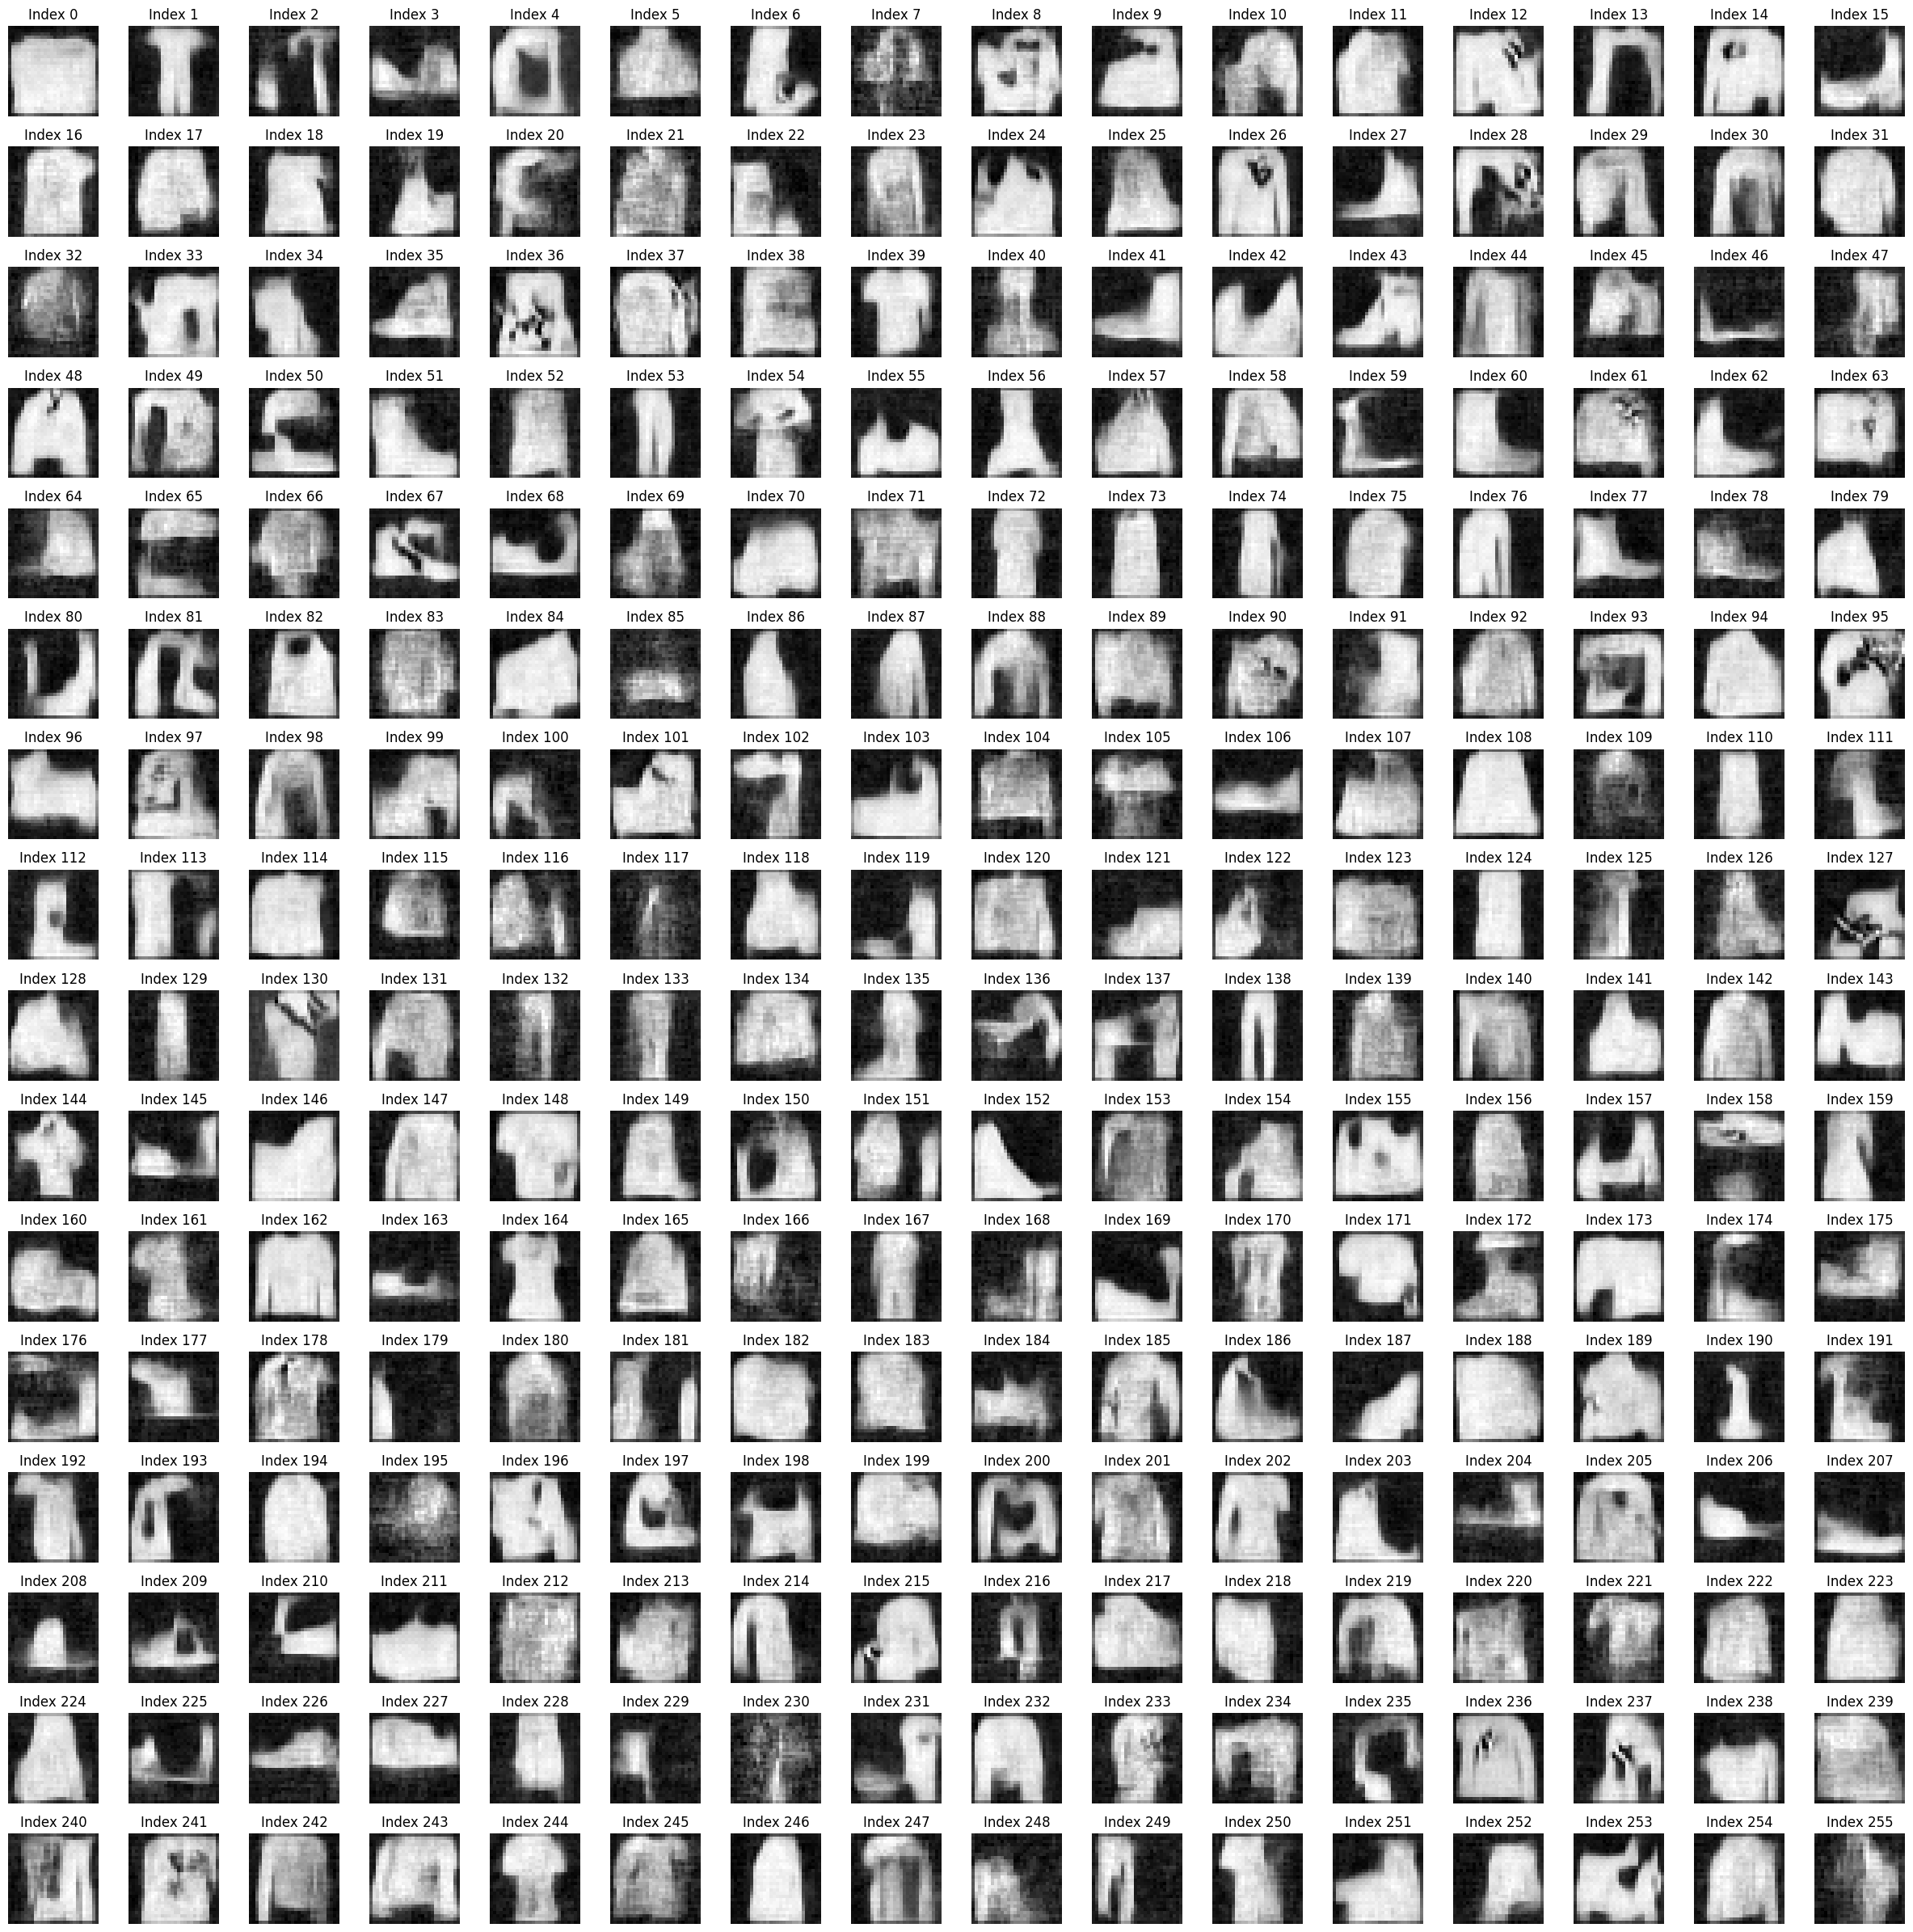

In [254]:
shape = [256,1,28,28]

samples2 = sample(model2, shape)

plt.figure(figsize=(24, 24)) 

for i in range(shape[0]):
    plt.subplot(16, 16, i+1) 
    plt.imshow(samples2[-1][i,:,:,:].reshape(28, 28), cmap="gray") 
    plt.title(f"Index {i}")
    plt.axis('off') 

plt.tight_layout()
plt.show()

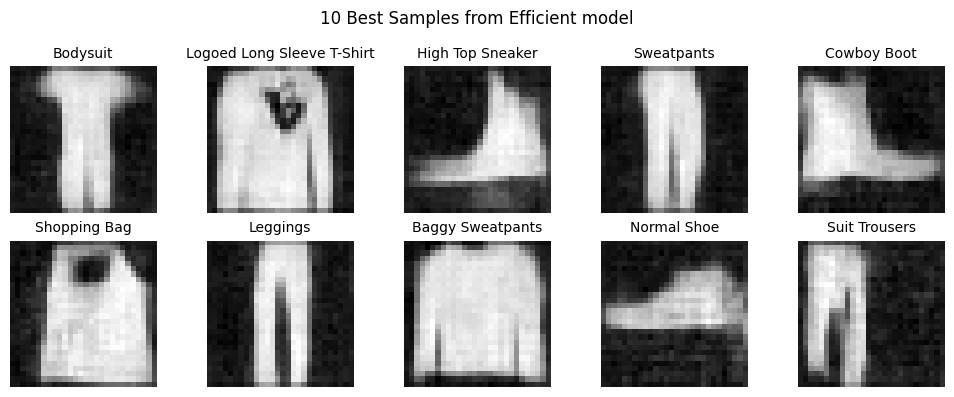

In [275]:
index = [1, 26, 27, 53, 77, 82, 138, 162, 226, 249]
Names = ['Bodysuit',
          'Logoed Long Sleeve T-Shirt',
          'High Top Sneaker',
          'Sweatpants',
          'Cowboy Boot',
          'Shopping Bag',
          'Leggings',
          'Baggy Sweatpants',
          'Normal Shoe',
          'Suit Trousers']

plt.figure(figsize=(10, 4))  

plt.suptitle('10 Best Samples from Efficient model')

for i, idx in enumerate(index):
    plt.subplot(2, 5, i + 1) 
    plt.imshow(samples2[-1][idx, :, :, :].reshape(28, 28), cmap="gray")
    plt.title(f"{Names[i]}", fontsize=10)
    plt.axis('off')  

plt.tight_layout()
plt.show()

### The plots below show

- The average MSE loss for different timesteps intervals over each training epoch.

- The Side by side comparisons of original images, their associated generated noisy images and the neural network's prediction of the original image, sampled at every 5th epoch and at random timesteps.

- The progression of static images into the sample images generated.

for both the basic model and the efficient model.

### Interpretation of the Results

As the number of epochs increases the average loss tends to decrease. From experementing with different models, and from compareing the basic and efficient models it is clear that the number of model parameters is inversely related to the average loss at each epoch. This is likely true because as the number of optimizable parameters increases said model can take the tweak different weights and biases at each training epoch leading to more properties and relationships in the model being picked up.

As can be seen when compareing each models predictions to the orginal images, the broad underlying shape of the clothing item is coming to form even in very early training epochs. This shows that each model has a primitive understanding of the shapes of the underlying images relatively early on in the training procces. When the time distortion is very large the shape of the underlying images is generally still visible. 

When the training epoch is small or the timestep is large there is significantly more static than what would otherwise be so. This could be because the Mean Squared Error (MSE) loss function was used, in which the loss increases quadratically as the difference between the predicted noise and the actual noise increases linearly, promoting the model to hedge it's prediction by adding small amounts of white colour to places around the predicted clothing items shape where the model is less sure how much static there is. This however can cause there to be static in places in which a human can clearly see there shouldn't be static.

Initially unintuitive, when the timestep is small (i.e. less than 100) the MSE loss is noticably bigger compared to when the timestep is bigger. There seems to be an inverse relationship between the timestep value and the MSE loss. This is likely due to the fact that both neural networks are used to predict the added noise in an image, so when the noise has a smaller influence on the noisy image the model has a harder time understanding where the noise is. Since bad prediction for lower timestep images are not as equally bad prediction to high timestep, a potential way to increase the predicted images perceived accuracy would be to increases the value of losses for large timesteps and decreases the losses on smaller timesteps. 

The models have trouble interpreting small details, for example the straps on heels or designs on t-shirts, instead focusing more on very broad shapes. This is likely the reason that high quality generated samples of plain long sleeve t-shirts or boots are much easier to find than of items that require more details like heels or sandals.

In [172]:
# Swap the losses collected so each list represents losses at different times
loss_tracker_list1 = [[x[i] for x in loss_tracker_list1] for i in range(len(loss_tracker_list1[0]))]
loss_tracker_list2 = [[x[i] for x in loss_tracker_list2] for i in range(len(loss_tracker_list2[0]))]

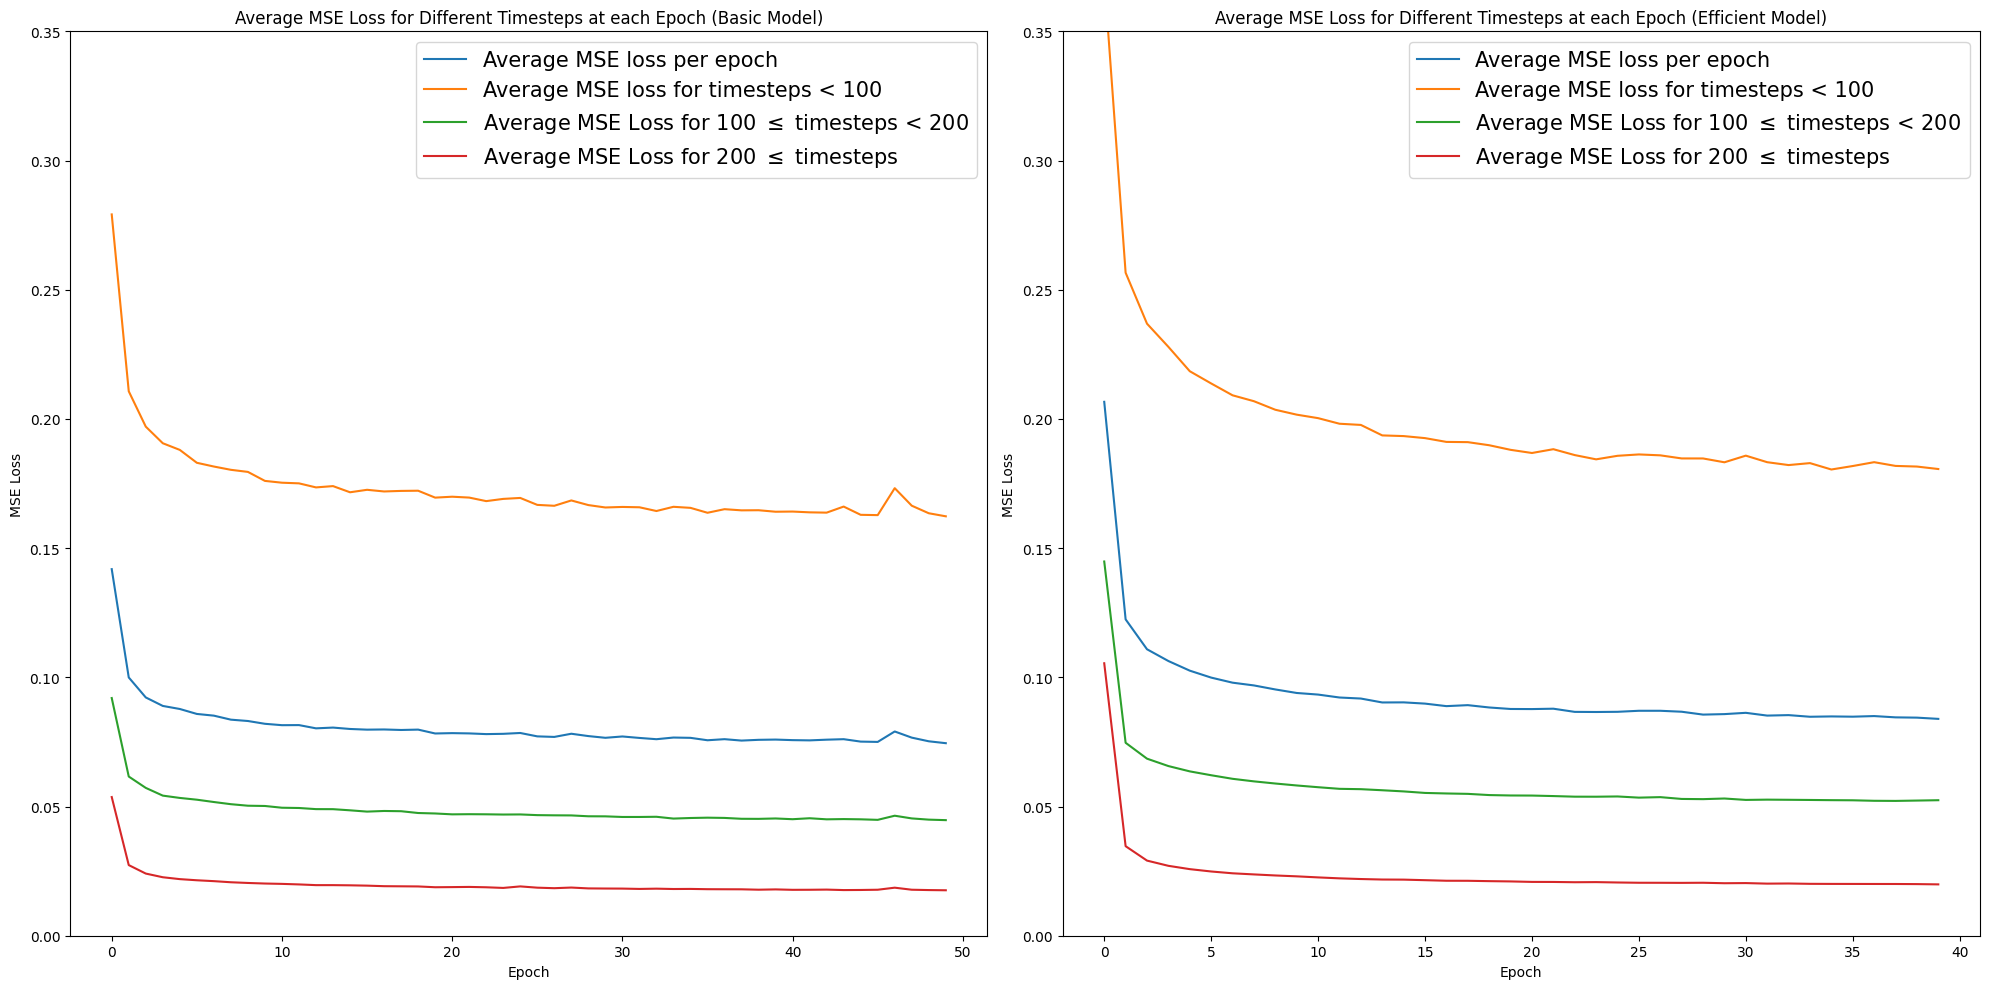

In [274]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))  


axes[0].plot(loss_tracker_list1[0], label='Average MSE loss per epoch')
axes[0].plot(loss_tracker_list1[1], label='Average MSE loss for timesteps < 100')
axes[0].plot(loss_tracker_list1[2], label='Average MSE Loss for 100 $\leq$ timesteps < 200')
axes[0].plot(loss_tracker_list1[3], label='Average MSE Loss for 200 $\leq$ timesteps')
axes[0].legend(fontsize=15)
axes[0].set_title('Average MSE Loss for Different Timesteps at each Epoch (Basic Model)')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')
axes[0].set_ylim(0,.35)


axes[1].plot(loss_tracker_list2[0], label='Average MSE loss per epoch')
axes[1].plot(loss_tracker_list2[1], label='Average MSE loss for timesteps < 100')
axes[1].plot(loss_tracker_list2[2], label='Average MSE Loss for 100 $\leq$ timesteps < 200')
axes[1].plot(loss_tracker_list2[3], label='Average MSE Loss for 200 $\leq$ timesteps')
axes[1].legend(fontsize=15)
axes[1].set_title('Average MSE Loss for Different Timesteps at each Epoch (Efficient Model)')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MSE Loss')
axes[1].set_ylim(0,.35)

plt.tight_layout()  
plt.show()  


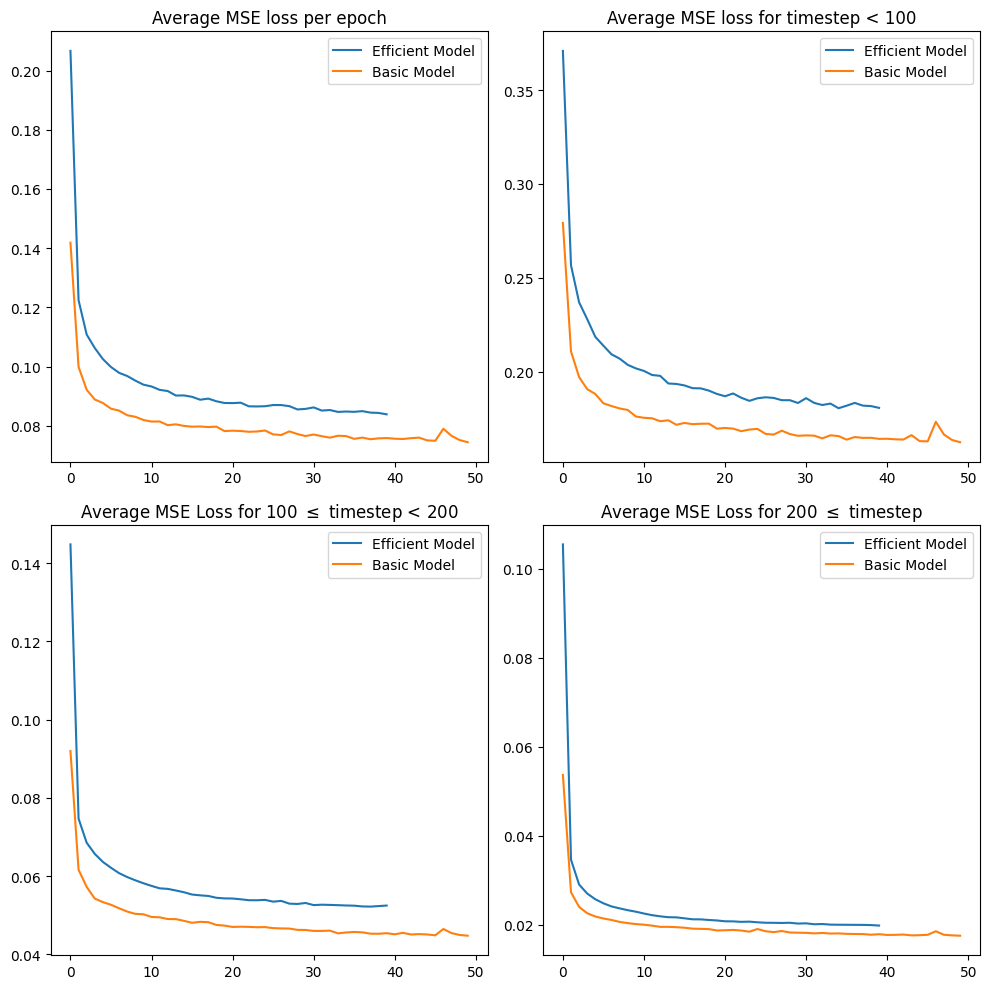

In [189]:


fig, axes = plt.subplots(2, 2, figsize=(10, 10))  

titles = ['Average MSE loss per epoch'
          ,'Average MSE loss for timestep < 100'
          ,'Average MSE Loss for 100 $\leq$ timestep < 200'
          ,'Average MSE Loss for 200 $\leq$ timestep']

for i in range(2):
    for j in range(2):
        ax = axes[i,j]
        ax.plot(loss_tracker_list2[2 * i + j], label=f'Efficient Model')
        ax.plot(loss_tracker_list1[2 * i + j], label=f'Basic Model')
        ax.set_title(titles[2 * i + j])
        ax.legend()

plt.tight_layout()  
plt.show()  


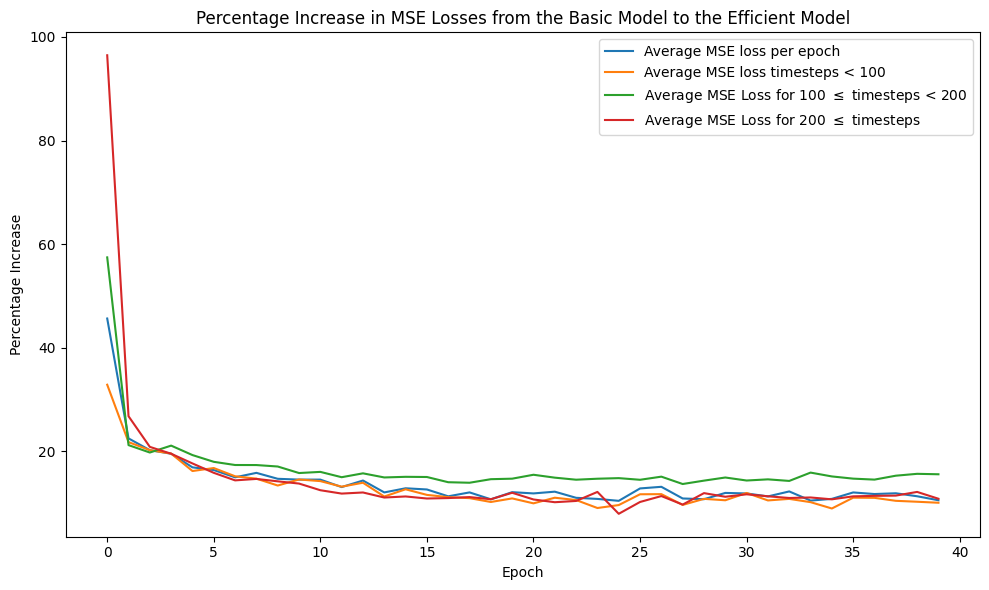

In [191]:
fig, ax = plt.subplots(figsize=(10, 6)) 
titles = ['Average MSE loss per epoch'
          ,'Average MSE loss timesteps < 100'
          ,'Average MSE Loss for 100 $\leq$ timesteps < 200'
          ,'Average MSE Loss for 200 $\leq$ timesteps']
for i in range(4):
    percentage_change = ((np.array(loss_tracker_list2[i]) - 
                         np.array(loss_tracker_list1[i])[:40]) / ((np.array(loss_tracker_list1[i])[:40]))) * 100
    # Plot the percentage difference
    ax.plot(percentage_change, label=f'{titles[i]}')
ax.legend()
ax.set_title('Percentage Increase in MSE Losses from the Basic Model to the Efficient Model')
ax.set_xlabel('Epoch')
ax.set_ylabel('Percentage Increase')

plt.tight_layout()
plt.show()


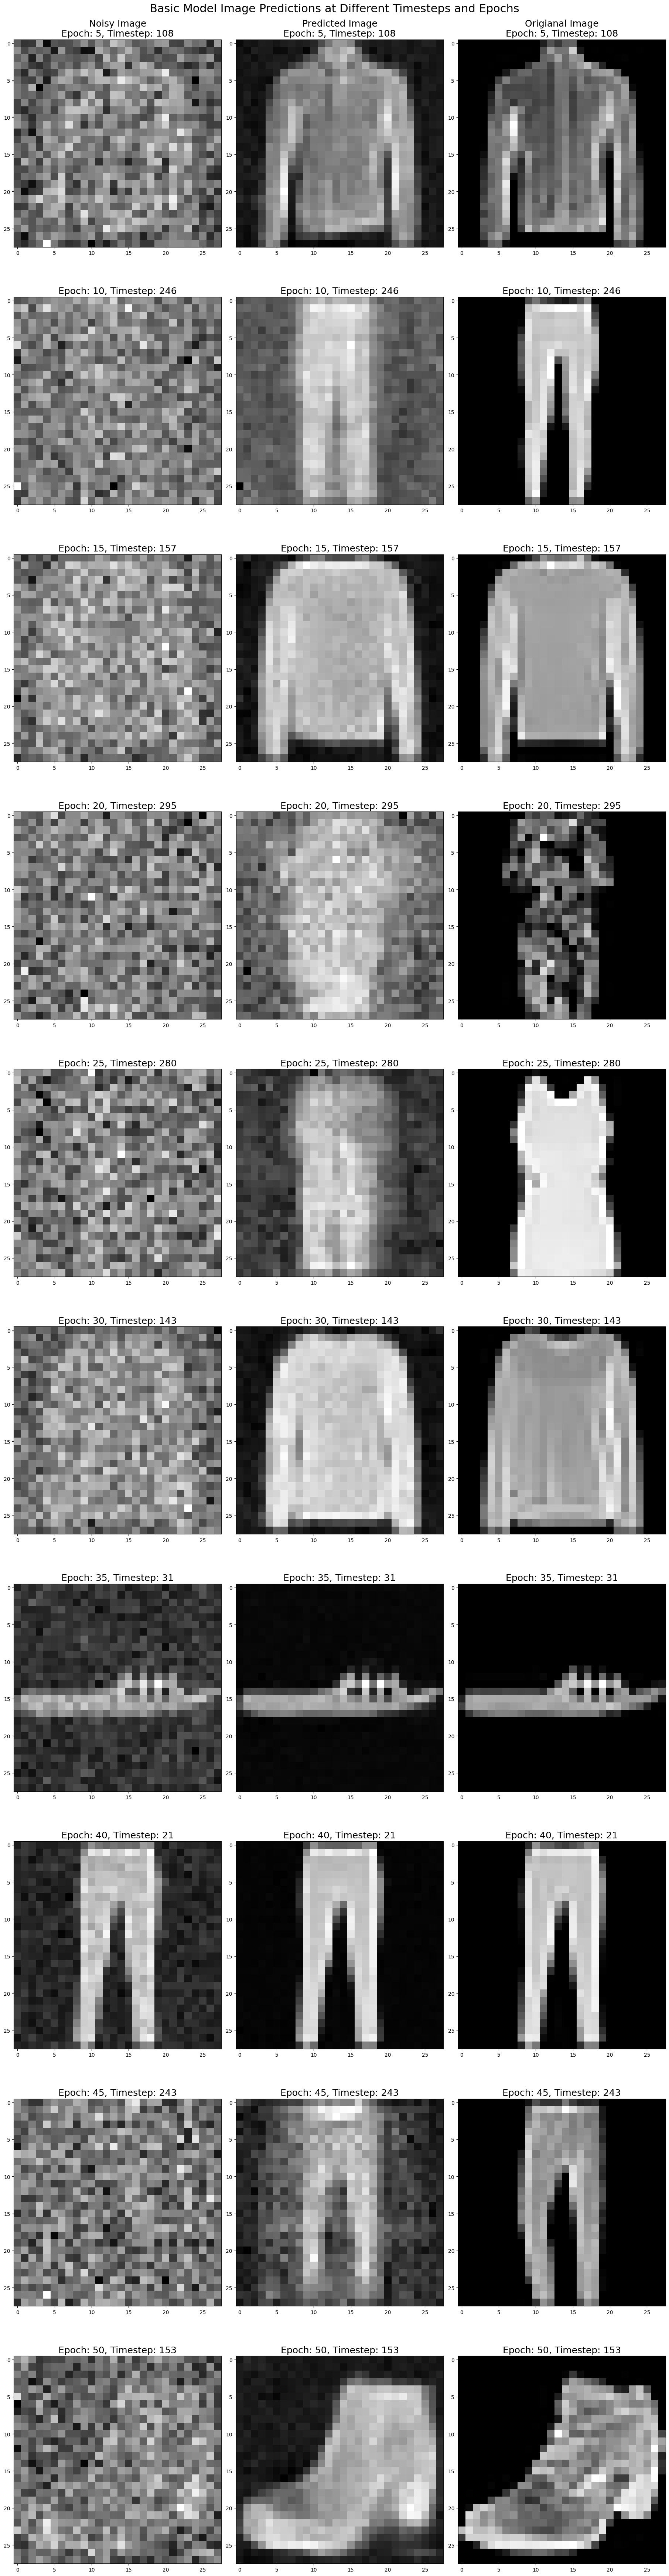

In [199]:

number_of_samples = len(image_pred_tracker1)
Image_types = 3  
titles = ['Noisy Image', 'Predicted Image', 'Origianal Image']


fig, axes = plt.subplots(number_of_samples, Image_types, figsize=(18, 7 * number_of_samples), constrained_layout=True)
fig.suptitle('Basic Model Image Predictions at Different Timesteps and Epochs', fontsize=22)
for j in range(number_of_samples):
    for i in range(Image_types):
        ax = axes[j, i]
        ax.imshow(image_pred_tracker1[j][i].cpu().detach().numpy().reshape(28, 28), cmap="gray")
        if j == 0:
            ax.set_title(f'{titles[i]}\nEpoch: {image_pred_tracker1[j][4] + 1}, Timestep: {int(image_pred_tracker1[j][3] + 1)}'
                         , fontsize=18)
        else:
            ax.set_title(f'Epoch: {image_pred_tracker1[j][4] + 1}, Timestep: {image_pred_tracker1[j][3] + 1}'
                         , fontsize=18)
plt.show()

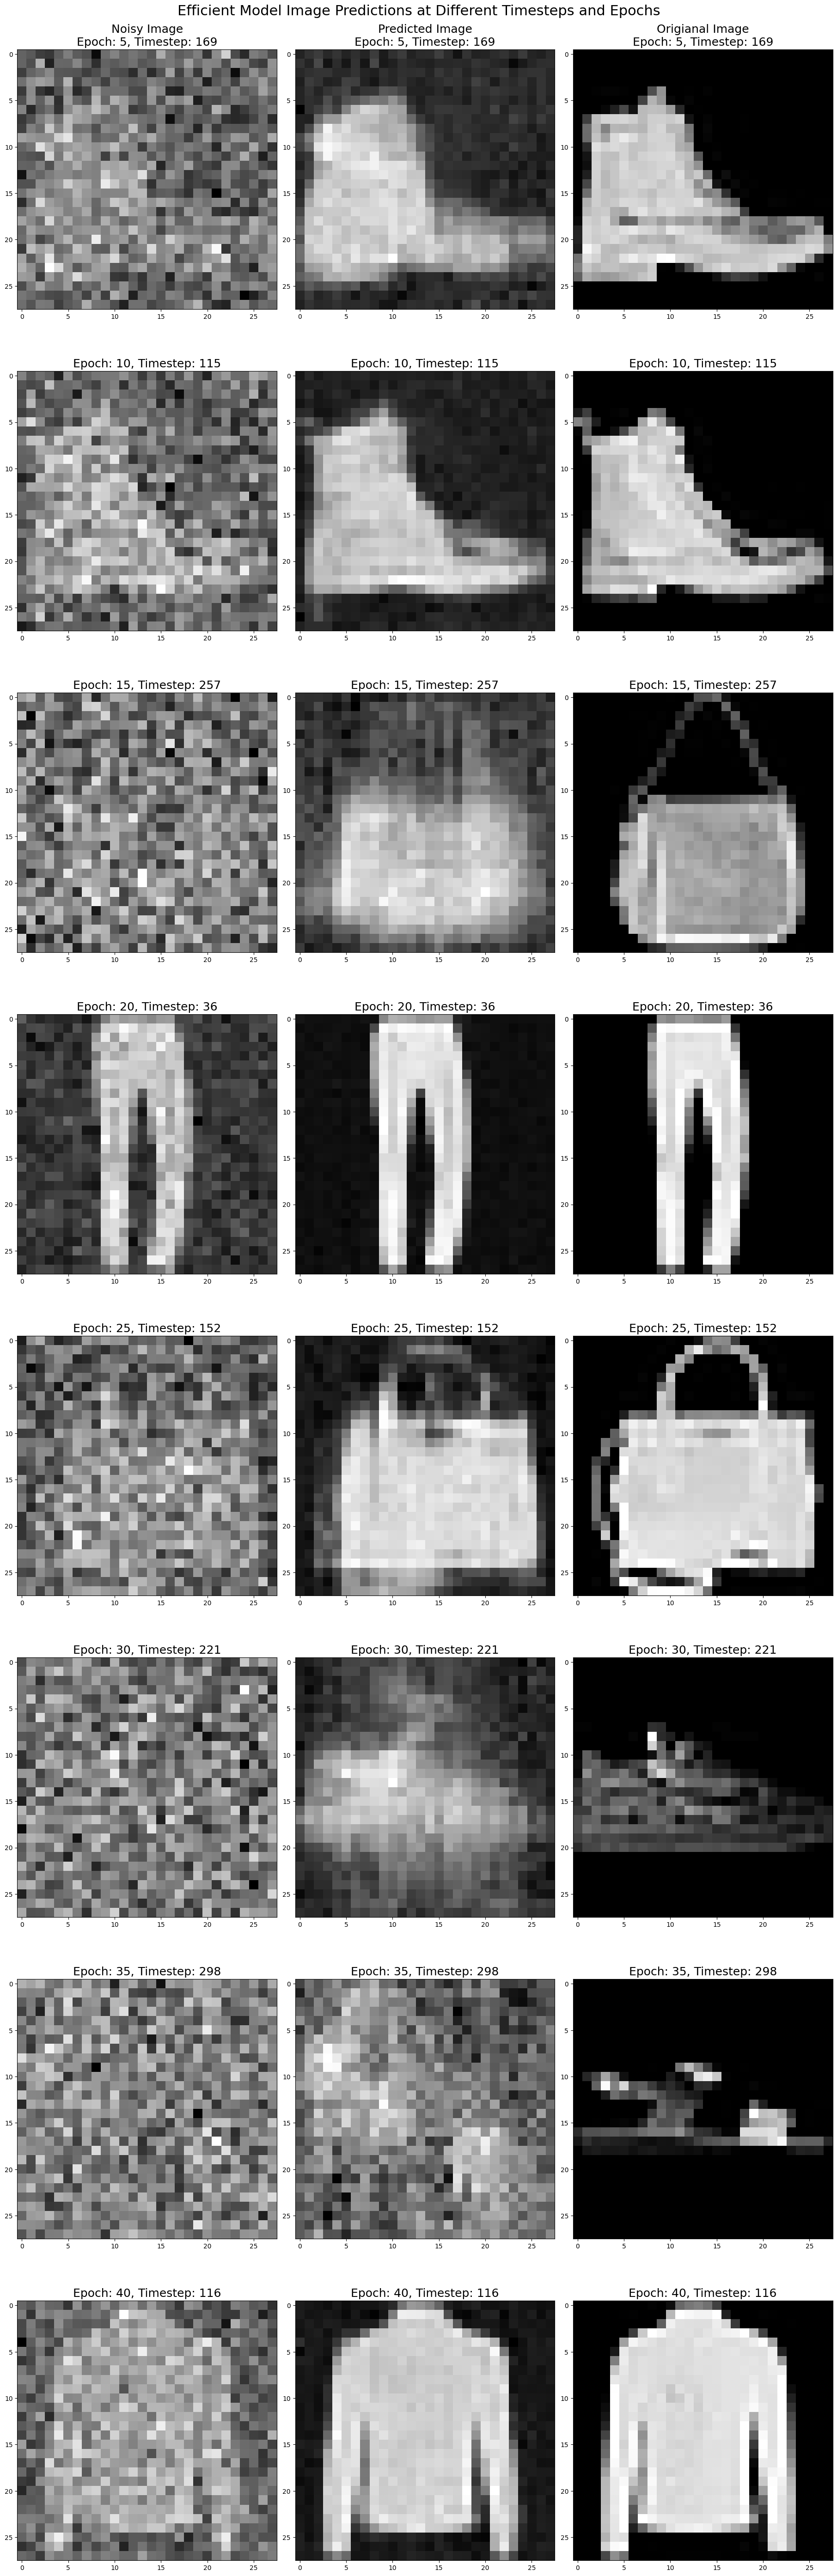

In [272]:

number_of_samples = len(image_pred_tracker2)
Image_types = 3  
titles = ['Noisy Image', 'Predicted Image', 'Origianal Image']


fig, axes = plt.subplots(number_of_samples, Image_types, figsize=(18, 7 * number_of_samples), constrained_layout=True)
fig.suptitle('Efficient Model Image Predictions at Different Timesteps and Epochs', fontsize=22)
for j in range(number_of_samples):
    for i in range(Image_types):
        ax = axes[j, i]
        ax.imshow(image_pred_tracker2[j][i].cpu().detach().numpy().reshape(28, 28), cmap="gray")
        if j == 0:
            ax.set_title(f'{titles[i]}\nEpoch: {image_pred_tracker2[j][4] + 1}, Timestep: {int(image_pred_tracker2[j][3] + 1)}'
                         , fontsize=18)
        else:
            ax.set_title(f'Epoch: {image_pred_tracker2[j][4] + 1}, Timestep: {int(image_pred_tracker2[j][3] + 1)}'
                         , fontsize=18)

plt.show()

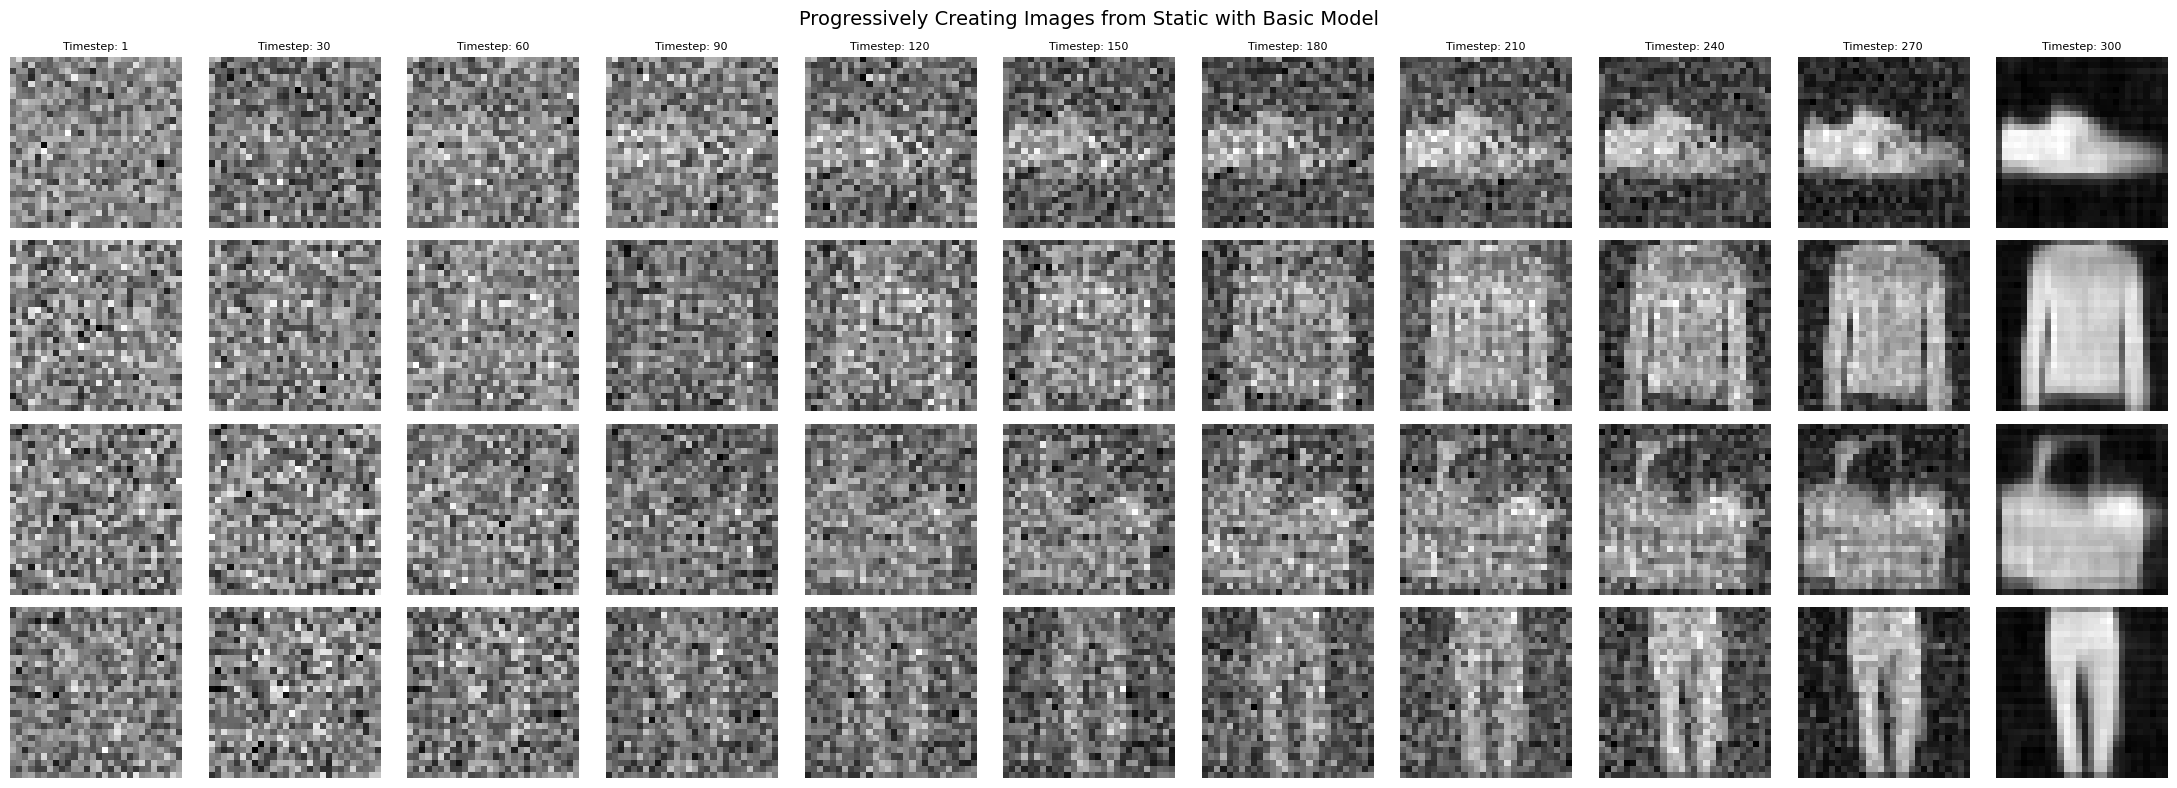

In [247]:

samples1_index = [12, 15, 16, 23]
num_samples = len(samples1_index)
steps_per_sample = 11

fig, axes = plt.subplots(num_samples, steps_per_sample, figsize=(22, 2*num_samples))

for i, sample in enumerate(samples1_index):
    for j in range(steps_per_sample):
        step = max(j*30 - 1, 0)
        ax = axes[i, j] 
        ax.imshow(samples1[step][sample, 0, :, :], cmap="gray")
        ax.axis('off') 
        if i == 0:
            ax.set_title(f'Timestep: {step+1}', fontsize=8)

fig.suptitle('Progressively Creating Images from Static with Basic Model', fontsize=14)

plt.tight_layout() 
plt.show()


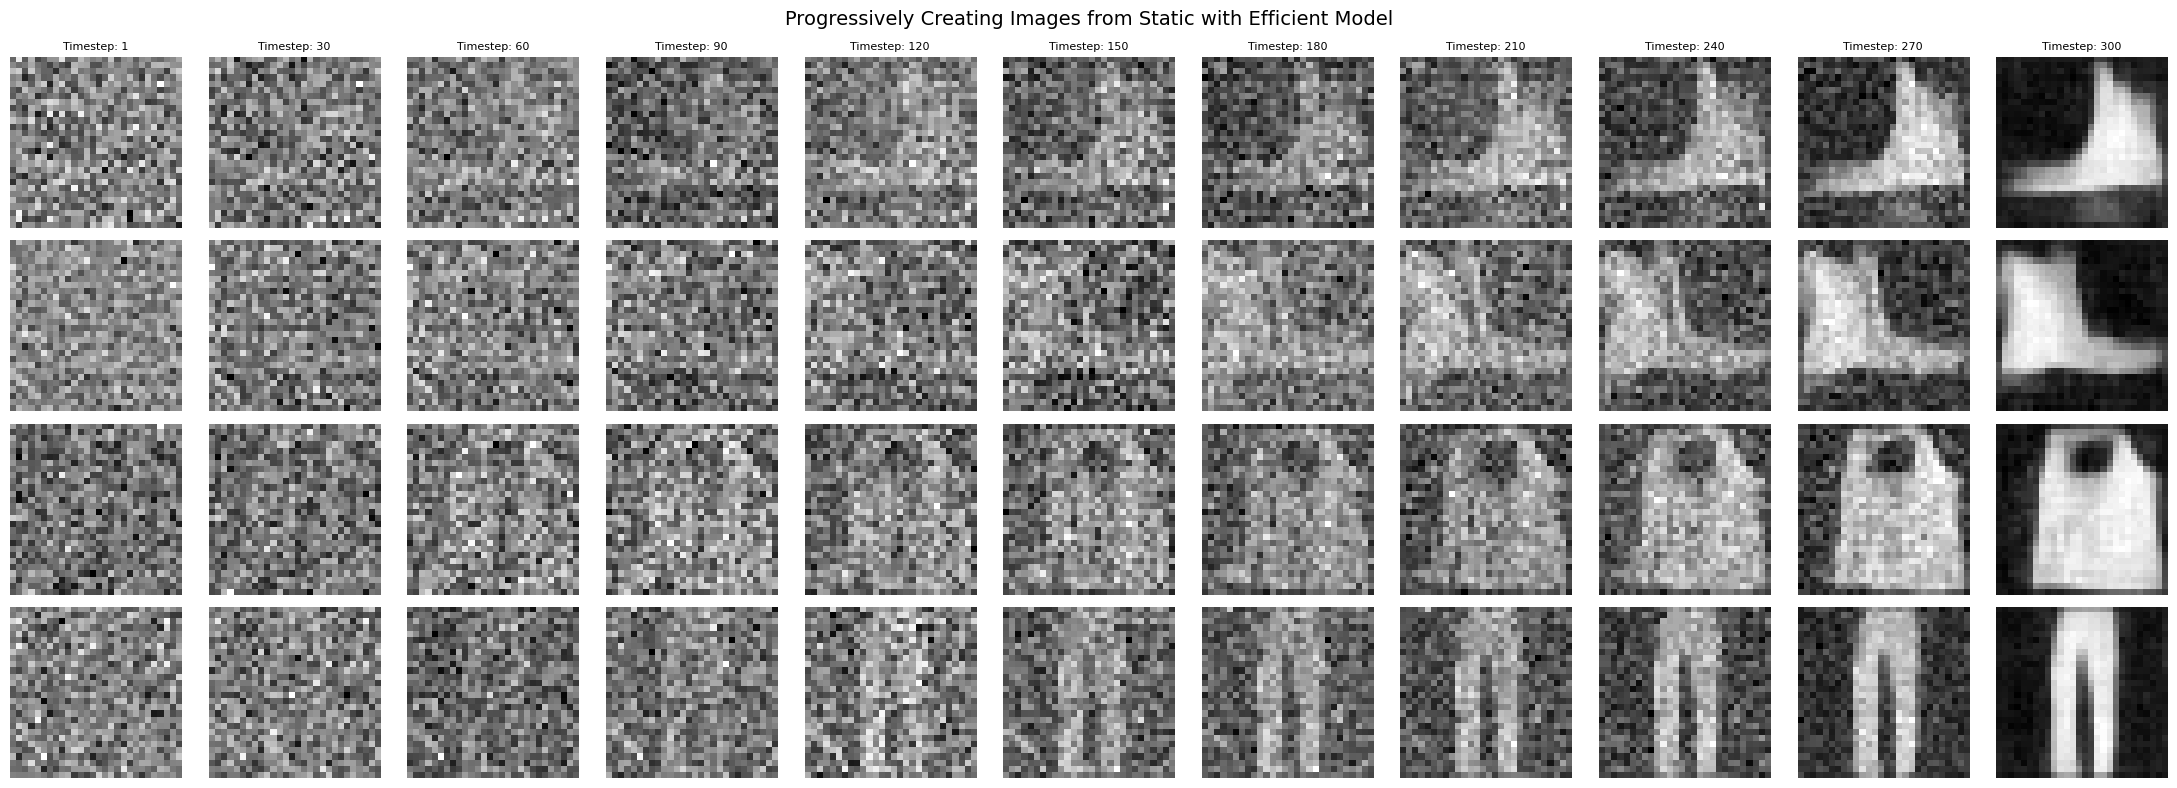

In [246]:
samples2_index = [27, 77, 82, 138]
 
num_samples = len(samples2_index)
number_of_timesteps = 11

fig, axes = plt.subplots(num_samples, number_of_timesteps, figsize=(22, 2*num_samples))

for i, sample in enumerate(samples2_index):
    for j in range(number_of_timesteps):
        step = max(j*30 - 1, 0)
        ax = axes[i, j] 
        ax.imshow(samples2[step][sample, 0, :, :], cmap="gray")
        ax.axis('off')
        if i == 0:
            ax.set_title(f'Timestep: {step + 1}', fontsize=8)
fig.suptitle('Progressively Creating Images from Static with Efficient Model', fontsize=14)
plt.tight_layout()  
plt.show()